In [1]:
#Training the model on 30k datasets.

import random
import numpy as np
from Bio import SeqIO
import gzip
import os
import pickle
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt

#Set random seeds for reproducibility.
np.random.seed(4)
random.seed(5)
set_random_seed(4) 



def load_data(path):   
    data = gzip.open(os.path.join(path,"sequences.fa.gz"),"rt")
    return data


def get_seq(protein, t_data, training_set_number): 
    if t_data == "train":
                
        training_data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((30000,101,4))          
    
    elif t_data == "test":    
                
        training_data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((10000,101,4))      
      
    r = 0    
      
    
    for record in SeqIO.parse(training_data,"fasta"):
        sequence = list(record.seq)                
        nucleotide = {'A' : 0, 'T' : 1, 'G' : 2, 'C' : 3, 'N' : 4} 
        num_seq = list() #sekvenca v številskem formatu


        for i in range(0,len(sequence)):
                num_seq.append(nucleotide[sequence[i]])


        X = np.zeros((1,len(num_seq),4))

        
        for i in range (len(num_seq)):
                if num_seq[i] <= 3:
                    X[:,i,num_seq[i]] = 1               

        x_train[r,:,:] = X
        r = r + 1
    
    return x_train


def get_class(protein, t_data,training_set_number):
    y_train = []
    

    if t_data == 'train':
        data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))

    elif t_data == 'test':
        data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))


    for record in SeqIO.parse(data,"fasta"):
        v = int((record.description).split(":")[1])
        # [1,0] if there was no observed binding and [0,1] for sequences where binding was observed.
        y_train.append([int(v == 0), int(v != 0)])

    y_train = np.array(y_train)
    return y_train


def get_cobinding(protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
            
        cobinding = np.zeros((30000,101,cobinding_data.shape[1]/101),dtype=np.int)    
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
        cobinding = np.zeros((10000,101,cobinding_data.shape[1]/101),dtype=np.int)
   
    
    for n in range(0,cobinding_data.shape[1],101):
        a = cobinding_data[:,n:(n+101)]
        cobinding[:,:,(n/101)] = a
    
    return cobinding
    

def get_region (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1)
        region = np.zeros((30000,101,region_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1) 
        region = np.zeros((10000,101,region_data.shape[1]/101),dtype=np.int)
    

    for n in range(0,region_data.shape[1],101):
        a = region_data[:,n:(n+101)]
        region[:,:,(n/101)] = a
        
    return region


def get_fold (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((30000,101,fold_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((10000,101,fold_data.shape[1]/101),dtype=np.int)




    for n in range(0,fold_data.shape[1],101):
        a = fold_data[:,n:(n+101)]
        fold[:,:,(n/101)] = a
    
    
    return fold

def load_data_sources(protein, t_data, training_set_number, *args):
    X = np.array([])
    data_sources = []
    for arg in args:
        
        if arg == 'KMER':
            if X.size == 0:
                X = get_seq(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_seq(protein, t_data, training_set_number)))
        if arg == 'RNA': 
            if X.size == 0:
                X = get_fold(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_fold(protein, t_data, training_set_number)))
        if arg == 'RG':   
            if X.size == 0:
                X = get_region(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_region(protein, t_data, training_set_number)))
        if arg == 'CLIP': 
            if X.size == 0:
                X = get_cobinding(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_cobinding(protein, t_data, training_set_number)))
        data_sources.append(arg)
        
    data_sources = ','.join(data_sources)
    return data_sources, X


Using TensorFlow backend.


1_PARCLIP_AGO1234_hg19
2_PARCLIP_AGO2MNASE_hg19
3_HITSCLIP_Ago2_binding_clusters
4_HITSCLIP_Ago2_binding_clusters_2
5_CLIPSEQ_AGO2_hg19
6_CLIP-seq-eIF4AIII_1
7_CLIP-seq-eIF4AIII_2
8_PARCLIP_ELAVL1_hg19
9_PARCLIP_ELAVL1MNASE_hg19
10_PARCLIP_ELAVL1A_hg19
10_PARCLIP_ELAVL1A_hg19
12_PARCLIP_EWSR1_hg19
13_PARCLIP_FUS_hg19
14_PARCLIP_FUS_mut_hg19
15_PARCLIP_IGF2BP123_hg19
16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters
17_ICLIP_HNRNPC_hg19
18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome
19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome
20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome
21_PARCLIP_MOV10_Sievers_hg19
22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome
23_PARCLIP_PUM2_hg19
24_PARCLIP_QKI_hg19
25_CLIPSEQ_SFRS1_hg19

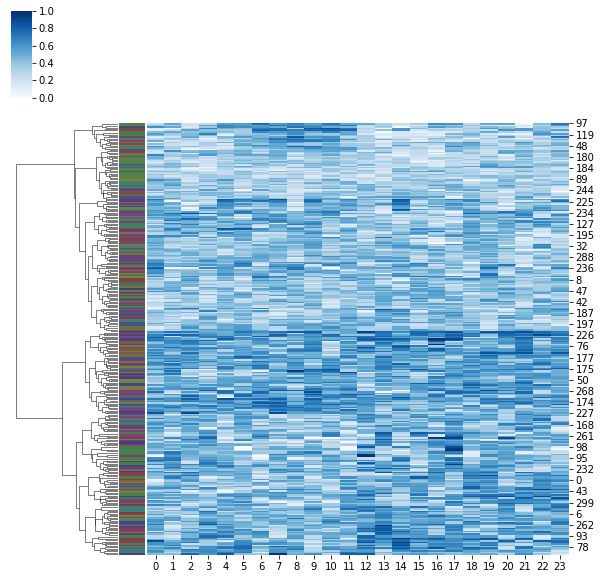

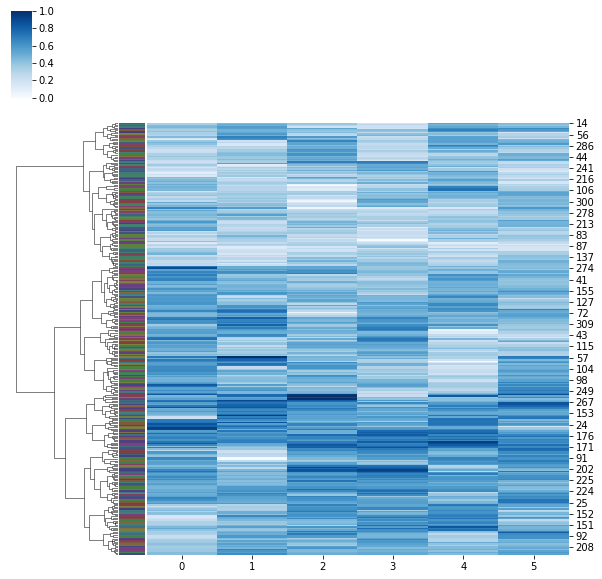

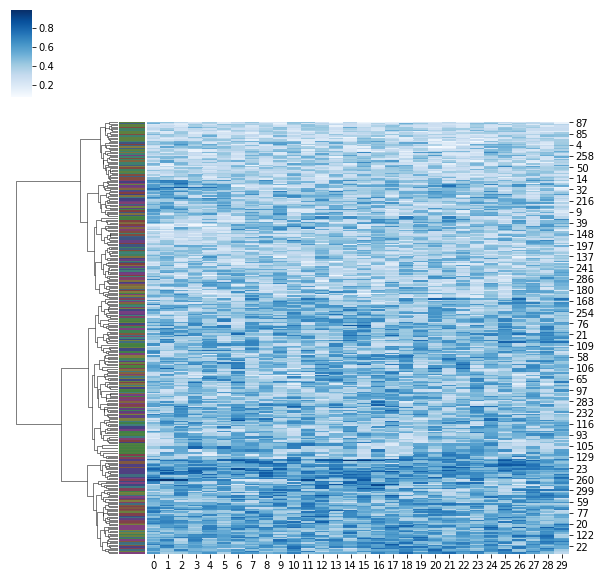

In [84]:
from keras.models import model_from_json
from IPython.display import display, Image
import seaborn as sns
import itertools
import colorsys

N = 31
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
colors = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
row_colors = list(itertools.chain.from_iterable(itertools.repeat(x, 10) for x in colors))


protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']
experiment_filters = {}
filters_array = np.zeros((60, 24))
for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
            filters, biases = model.layers[0].get_weights()
            
            filter_min, filter_max = filters.min(), filters.max()
            #normalize filter values
            filters = (filters - filter_min) / (filter_max - filter_min)
            # print(filters.shape)
            d_sources_filters = {'KMER': filters[:, 0:4, :],
                                 'RNA': filters[:, 4:5, :],
                                 'RG': filters[:, 5:10, :],
                                 'CLIP': filters[:, 10: , :]}

            experiment_filters[protein] = d_sources_filters
    
    print(experiment_filters["1_PARCLIP_AGO1234_hg19"]["RNA"].shape)

for source in ['KMER', 'RNA', 'RG']:
    print(source)

    filters_array = np.zeros((310, experiment_filters["1_PARCLIP_AGO1234_hg19"][source].shape[0]*experiment_filters["1_PARCLIP_AGO1234_hg19"][source].shape[1]))
    for p_multiplier, protein in enumerate(protein_list):
        for fi, filter in enumerate(np.transpose(experiment_filters[protein][source])):
        # print (np.array(filter).flatten())
            filters_array[fi+(p_multiplier*10)] = np.array(filter).flatten()

    sns.clustermap(filters_array, method='ward', col_cluster=False, cmap='Blues', row_colors=row_colors)
# print(filters_array)

# g = sns.clustermap(flat_source_arr, method = 'ward', col_cluster = False)                
                
# RNA : probability of double stranded structure
# RG :exon, intron, 5’UTR, 3’UTR, CDS
# KMER : A, U, G, C
# CLIP 



(6, 1, 10)
KMER


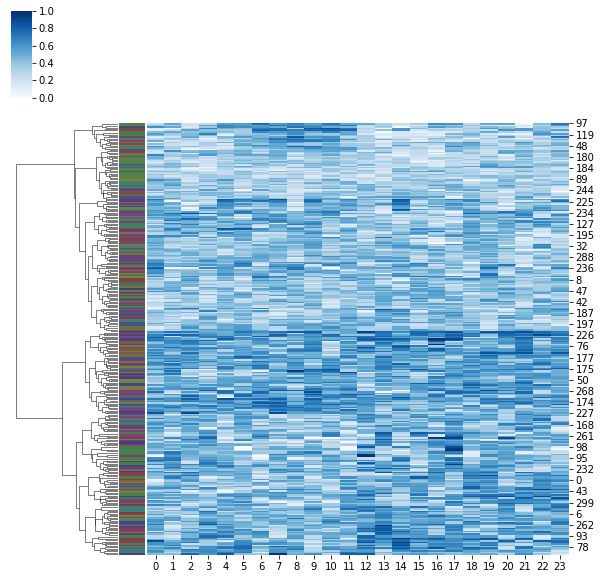

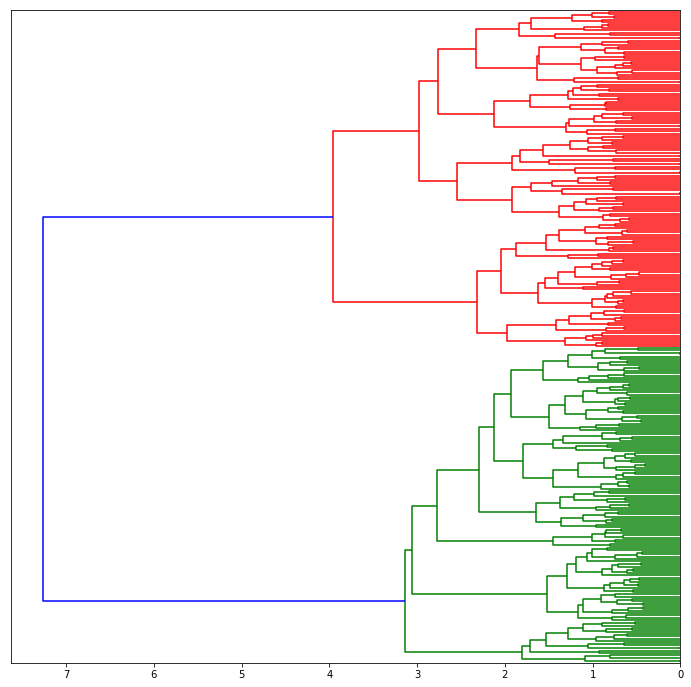

RNA


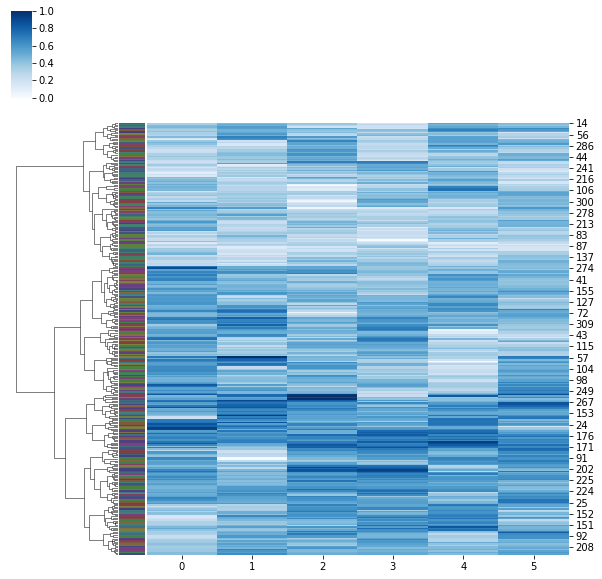

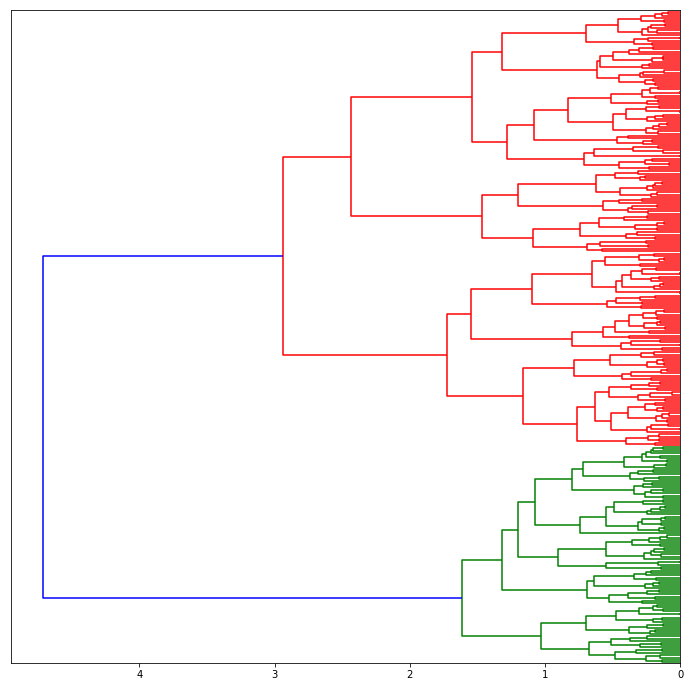

RG


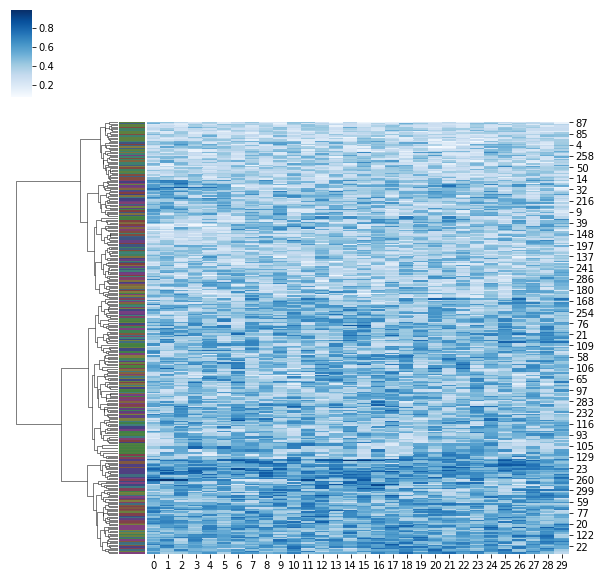

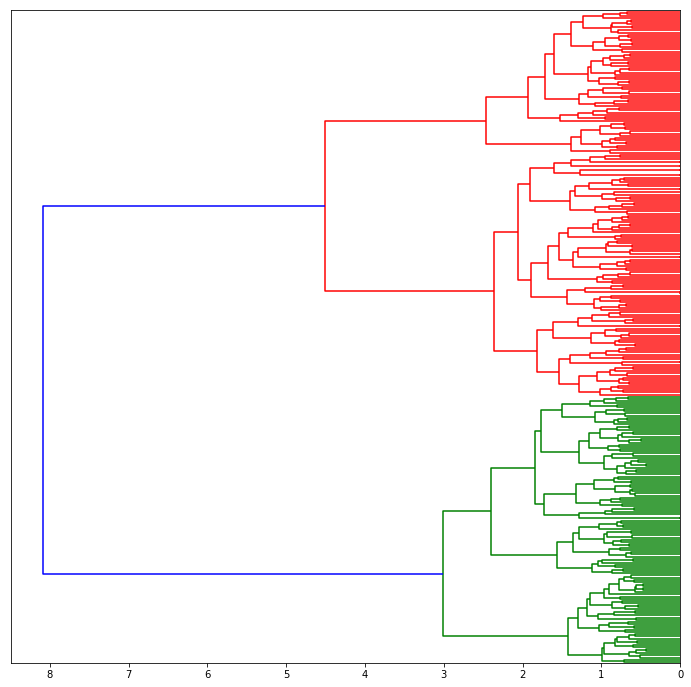

In [3]:
############
from keras.models import model_from_json
from IPython.display import display, Image
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import itertools
import colorsys

N = 31
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
colors = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
row_colors = list(itertools.chain.from_iterable(itertools.repeat(x, 10) for x in colors))


protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']
experiment_filters = {}
filters_array = np.zeros((60, 24))
for training_set_number in range (1):
    for protein in protein_list:
        # print (protein)
        
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
            filters, biases = model.layers[0].get_weights()
            
            filter_min, filter_max = filters.min(), filters.max()
            #normalize filter values
            filters = (filters - filter_min) / (filter_max - filter_min)
            # print(filters.shape)
            d_sources_filters = {'KMER': filters[:, 0:4, :],
                                 'RNA': filters[:, 4:5, :],
                                 'RG': filters[:, 5:10, :],
                                 'CLIP': filters[:, 10: , :]}

            experiment_filters[protein] = d_sources_filters
    
    print(experiment_filters["1_PARCLIP_AGO1234_hg19"]["RNA"].shape)

for source in ['KMER', 'RNA', 'RG']:
    print(source)

    filters_array = np.zeros((310, experiment_filters["1_PARCLIP_AGO1234_hg19"][source].shape[0]*experiment_filters["1_PARCLIP_AGO1234_hg19"][source].shape[1]))
    for p_multiplier, protein in enumerate(protein_list):
        for fi, filter in enumerate(np.transpose(experiment_filters[protein][source])):
        # print (np.array(filter).flatten())
            filters_array[fi+(p_multiplier*10)] = np.array(filter).flatten()

    sns.clustermap(filters_array, method='ward', col_cluster=False, cmap='Blues', row_colors=row_colors)
    
    Z = linkage(filters_array, 'ward')
    fig = plt.figure(figsize=(12, 12))
    dn = dendrogram(Z, orientation = 'left', no_labels = True)
    plt.show()
    
    
# print(filters_array)

# g = sns.clustermap(flat_source_arr, method = 'ward', col_cluster = False)                
                
# RNA : probability of double stranded structure
# RG :exon, intron, 5’UTR, 3’UTR, CDS
# KMER : A, U, G, C
# CLIP 



(6, 1, 10)
KMER
(310, 24)


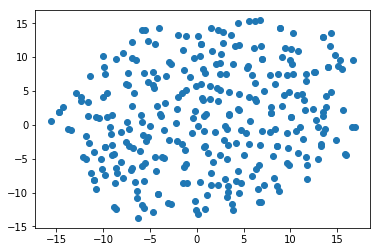

(310, 2)
RNA
(310, 6)


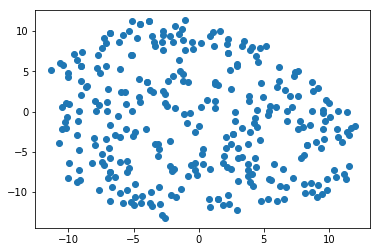

(310, 2)
RG
(310, 30)


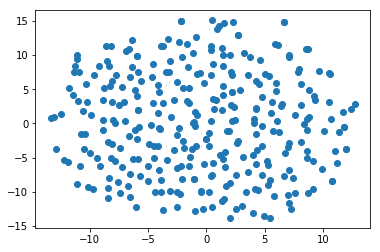

(310, 2)


In [7]:
from keras.models import model_from_json
from IPython.display import display, Image
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import itertools
import colorsys
from sklearn.manifold import TSNE
N = 31
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
colors = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
row_colors = list(itertools.chain.from_iterable(itertools.repeat(x, 10) for x in colors))


protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']
experiment_filters = {}
filters_array = np.zeros((60, 24))
for training_set_number in range (1):
    for protein in protein_list:
        # print (protein)
        
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
            filters, biases = model.layers[0].get_weights()
            
            filter_min, filter_max = filters.min(), filters.max()
            #normalize filter values
            filters = (filters - filter_min) / (filter_max - filter_min)
            # print(filters.shape)
            d_sources_filters = {'KMER': filters[:, 0:4, :],
                                 'RNA': filters[:, 4:5, :],
                                 'RG': filters[:, 5:10, :],
                                 'CLIP': filters[:, 10: , :]}

            experiment_filters[protein] = d_sources_filters
    
    print(experiment_filters["1_PARCLIP_AGO1234_hg19"]["RNA"].shape)

for source in ['KMER', 'RNA', 'RG']:
    print(source)

    filters_array = np.zeros((310, experiment_filters["1_PARCLIP_AGO1234_hg19"][source].shape[0]*experiment_filters["1_PARCLIP_AGO1234_hg19"][source].shape[1]))
    for p_multiplier, protein in enumerate(protein_list):
        for fi, filter in enumerate(np.transpose(experiment_filters[protein][source])):
        # print (np.array(filter).flatten())
            filters_array[fi+(p_multiplier*10)] = np.array(filter).flatten()

    print(filters_array.shape)
    X_embeded = TSNE(n_components=2, metric="correlation", perplexity=40, learning_rate=100).fit_transform(filters_array)
    # print(X_embeded)
    x = [i[0] for i in X_embeded]
    y = [i[1] for i in X_embeded]
    plt.scatter(x, y)
    plt.show()
    print(X_embeded.shape)
    

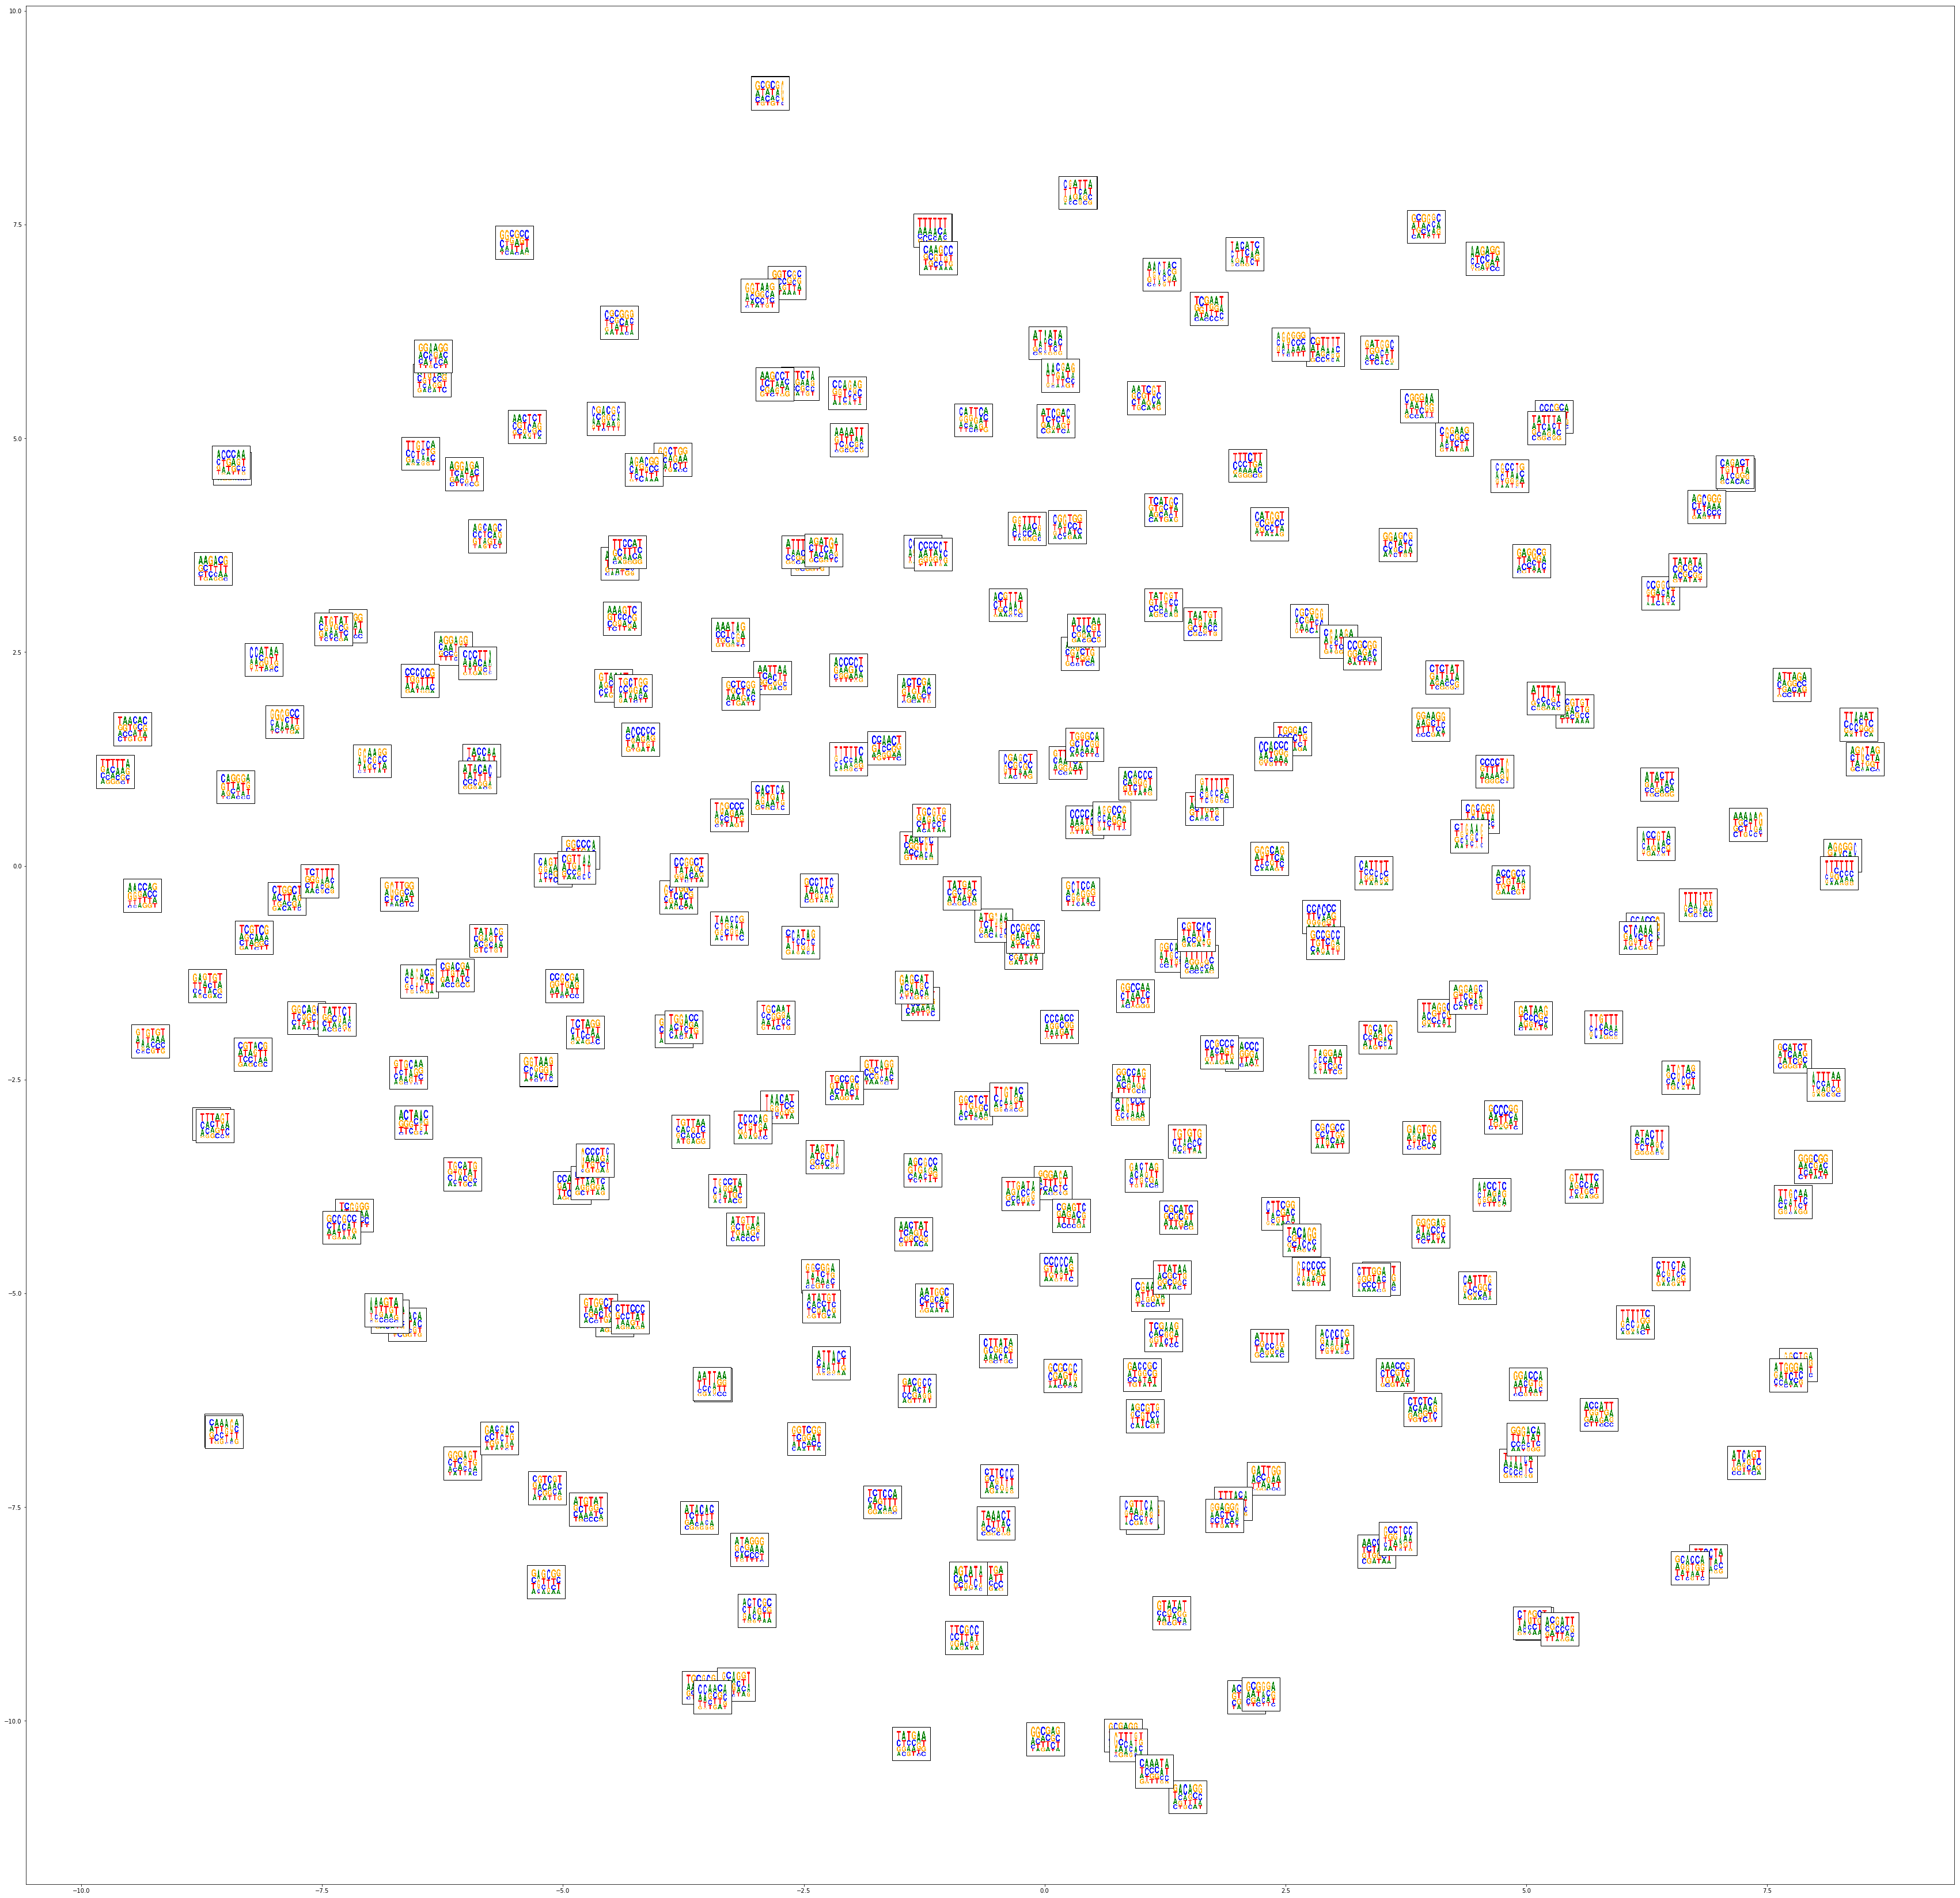

In [19]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg


def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
# d_source = "KMER"        
# fig, ax = plt.subplots(figsize=(15,15))
# filter_num = 0

# pic = mpimg.imread('filter.png')
# imagebox = OffsetImage(pic, zoom=0.2)

# ab = AnnotationBbox(pic, (loc_x, loc_y))
# ax.add_artist(ab)

# plt.show()

    
# for x_ch, y_ch in zip(chunks(x, 10), chunks(y, 10)):
#     ax.scatter(x_ch, y_ch)

# plt.imshow((d_sources_filters[d_source])[:,:,filter_num].T, cmap="binary")
# plt.axis("off")
# plt.savefig("filter.png")

d_source = "KMER"        
fig, ax = plt.subplots(figsize=(60, 60))
for protein, x_ch, y_ch in zip(protein_list, chunks(x, 10), chunks(y, 10)):
#     print(protein, x_ch, y_ch)
    for filter_num in xrange(10):
        fil_img = mpimg.imread("filters_png/{}_{}_{}.png".format(d_source, protein, filter_num))
        imagebox = OffsetImage(fil_img, zoom=0.4)
        plt.scatter(x_ch[filter_num], y_ch[filter_num])
        ax.add_artist(AnnotationBbox(imagebox, (x_ch[filter_num], y_ch[filter_num])))
plt.show()

In [2]:
import os
from IPython.display import display, Image
from keras.models import model_from_json
from scipy import ndimage
from Bio.Seq import Seq
from Bio import motifs
from Bio.Alphabet import IUPAC
# TESTING CELL


def set_model_filter(model, filter_number):
    filters, biases = model.layers[0].get_weights()
    zero_filter = np.zeros((filters.shape[0], filters.shape[1]))
    biases[filter_number] = 0
    filters[:, :, filter_number] = zero_filter
    model.layers[0].set_weights([filters, biases])
    return model


def get_filter_motifs(protein, training_set_number, experiment_set):
    # Predict binding without one filter and return ROC for each sample.
    filter_predictions = np.zeros((10, 10000))
    print(protein)
    
    
    def set_filter(protein, training_set_number, filter_number):
        #Set filter weigths to 0.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            original_model = model_from_json(json)
            original_model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
            model = set_model_filter(original_model, filter_number)
        return model
        

    def find_activation_max(protein, training_set_number, filter_predictions):
        # Find activation maximums of each filter for sequences were their activation was the highest.
        activation_max = []
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            original_model = model_from_json(json)
            original_model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
            filters, biases = model.layers[0].get_weights()
            for filter_number, x in zip(np.argmin(filter_predictions, axis=0), X_test):
                current_filter = filters[:, :, filter_number]
        #         print(current_filter.shape, x.shape)
                conv = np.zeros(x.shape)
                for row, (fil_row, x_row) in enumerate(zip(np.rollaxis(current_filter, 1), np.rollaxis(x, 1))):
        #             print(fil_row.shape, x_row.shape)
                    conv[:, row] = np.maximum(ndimage.convolve1d(x_row, weights=fil_row, mode="constant", origin=2), 0)
        #       print(conv.shape, conv[:, 35])
                activation_max.append(np.argmax(np.sum(conv, axis=1)))
        return activation_max


    def create_motiflogo(protein, training_set_number, filters_sequences, filter_predictions, filter_auc):
        for fil in filters_sequences.keys():
            cmd = ("weblogo -f filter_motifs/{1}/filter{0}_motif.txt -F png -o filter_motifs/{1}/motif{0}.png --errorbars NO --show-xaxis YES --show-yaxis YES -A dna --composition none --color '#00CC00' 'A' 'A' --color '#0000CC' 'C' 'C' --color '#FFB300' 'G' 'G' --color '#CC0000' 'T' 'T'".format(fil, protein))
            os.system(cmd)

        filter_nums = np.unique(np.argmin(filter_predictions, axis=0))
        filter_nums = [i for i in np.argsort(filter_auc) if i in filter_nums]
        print(filter_nums, filter_auc)
        for fil in filter_nums:
            display(Image('filter_motifs/{1}/motif{0}.png'.format(fil, protein)))


    def create_filter_sequences(protein, training_set_number, filter_predictions, activation_max):
        if not os.path.exists('filter_motifs/{}'.format(protein)):
            os.mkdir('filter_motifs/{}'.format(protein))

        test_sequences = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
        filters_sequences = {}
        for record, filter_number, index_max in zip(SeqIO.parse(test_sequences,"fasta"), np.argmin(filter_predictions, axis=0), activation_max):
            sequence = list(record.seq)[index_max:index_max+6]
            while len(sequence) < 6:
                sequence.append("N")
            motif = Seq("".join(sequence))
        #     print(motif)
            if filter_number in filters_sequences:
                filters_sequences[filter_number].append(motif)
            else:
                filters_sequences[filter_number] = [motif]
#         print(filters_sequences.keys())
        # print(filters_sequences[0])
        for filter_number, fil_seq in filters_sequences.iteritems():
            with open("filter_motifs/{}/filter{}_motif.txt".format(protein, filter_number), "w") as motif_file:
                for motif in fil_seq:
                    motif_file.write(str(motif) + "\n")
        return filters_sequences

    
    y_test = get_class(protein,"test",training_set_number)
    y_test = y_test [:,0:1]
    filter_auc = np.zeros(10)
    for filter_num in range(10):
            model = set_filter(protein, training_set_number, filter_num)
            #Load data for testing purposes.
            data_sources, X_test = load_data_sources(protein, 'test', training_set_number, *experiment_set)

            #Run predictions on test dataset and save them.
            predictions = model.predict(X_test)
            y_scores = predictions [:,0:1]
            filter_predictions[filter_num] = y_scores.flatten()
            filter_auc[filter_num] = roc_auc_score(y_test, y_scores)

    activation_max = find_activation_max(protein, training_set_number, filter_predictions)
    filter_sequences = create_filter_sequences(protein, training_set_number, filter_predictions, activation_max)
    create_motiflogo(protein, training_set_number, filter_sequences, filter_predictions, filter_auc)


1_PARCLIP_AGO1234_hg19
([6, 1, 9, 8, 7, 4, 0, 3, 2], array([0.93509841, 0.88179191, 0.93643897, 0.93551856, 0.93376519,
       0.92278041, 0.8484365 , 0.93362947, 0.93008719, 0.91783212]))


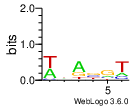

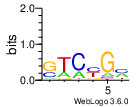

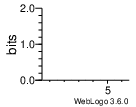

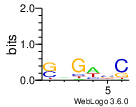

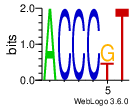

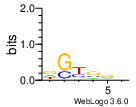

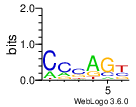

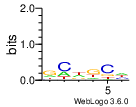

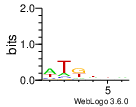

2_PARCLIP_AGO2MNASE_hg19
([3, 0, 6, 9, 7, 8, 4, 5], array([0.747012  , 0.73808981, 0.74504756, 0.74506769, 0.75081625,
       0.75201694, 0.74773662, 0.74851666, 0.75021841, 0.74811275]))


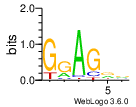

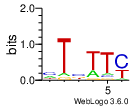

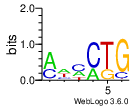

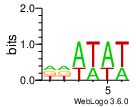

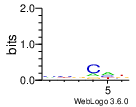

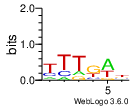

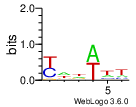

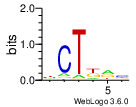

3_HITSCLIP_Ago2_binding_clusters
([0, 9, 5, 3, 2, 1, 6, 7, 4], array([0.88252469, 0.92678744, 0.91602569, 0.91346403, 0.93288828,
       0.91164959, 0.92856347, 0.93028559, 0.92885481, 0.90979394]))


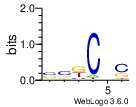

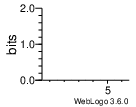

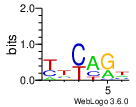

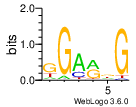

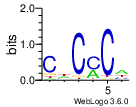

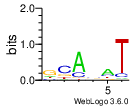

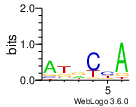

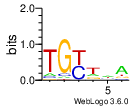

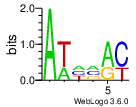

4_HITSCLIP_Ago2_binding_clusters_2
([4, 1, 3, 9, 5, 0, 6, 2, 7, 8], array([0.92674313, 0.91578791, 0.9310985 , 0.91759841, 0.90405888,
       0.925224  , 0.93106281, 0.93401925, 0.9367785 , 0.9216195 ]))


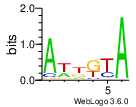

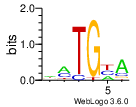

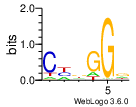

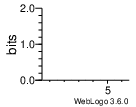

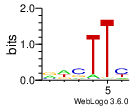

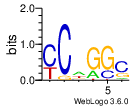

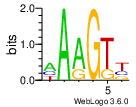

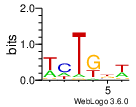

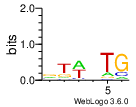

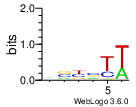

5_CLIPSEQ_AGO2_hg19
([9, 5, 1, 3, 6, 4, 2, 0, 7], array([0.76497541, 0.75910103, 0.76446031, 0.76206381, 0.764032  ,
       0.75683022, 0.7638235 , 0.76621381, 0.74778588, 0.73126856]))


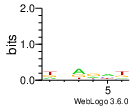

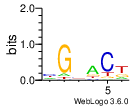

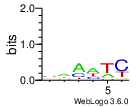

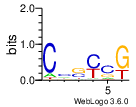

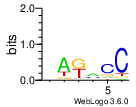

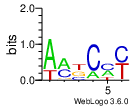

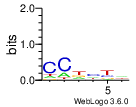

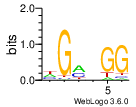

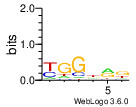

6_CLIP-seq-eIF4AIII_1
([2, 0, 3, 7, 5, 1, 4, 9, 8], array([0.93734922, 0.94987806, 0.83367125, 0.94572609, 0.95416925,
       0.94953444, 0.95685609, 0.94916353, 0.95700475, 0.95445181]))


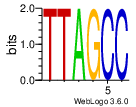

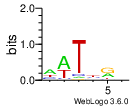

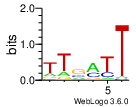

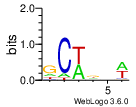

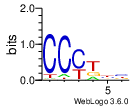

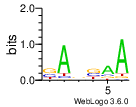

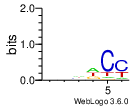

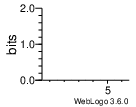

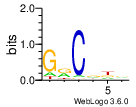

7_CLIP-seq-eIF4AIII_2
([6, 4, 5, 2, 1, 3, 8, 7, 0, 9], array([0.97608247, 0.96496419, 0.96389197, 0.96834422, 0.95454681,
       0.9619305 , 0.91459603, 0.97547875, 0.97194444, 0.97837734]))


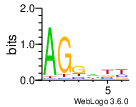

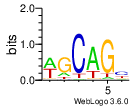

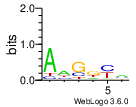

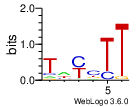

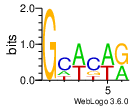

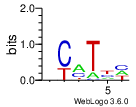

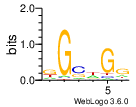

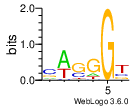

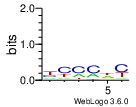

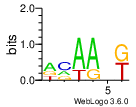

8_PARCLIP_ELAVL1_hg19
([3, 1, 8, 7, 2, 6, 9, 0, 5, 4], array([0.96565784, 0.95124106, 0.96346962, 0.925952  , 0.96582091,
       0.96568941, 0.96482144, 0.96094509, 0.95534256, 0.96551547]))


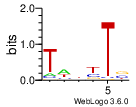

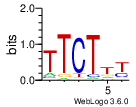

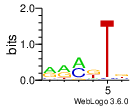

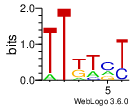

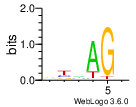

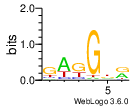

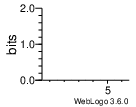

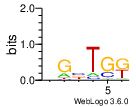

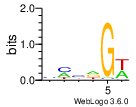

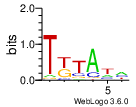

9_PARCLIP_ELAVL1MNASE_hg19
([8, 1, 4, 2, 9, 5, 6, 3, 0, 7], array([0.74683556, 0.73721522, 0.74024291, 0.74361838, 0.73958525,
       0.74331456, 0.74335859, 0.74746406, 0.72523025, 0.74238444]))


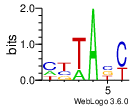

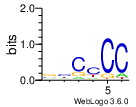

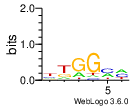

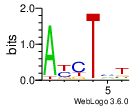

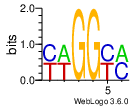

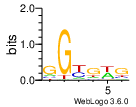

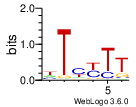

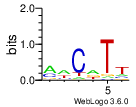

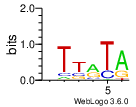

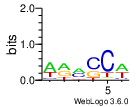

10_PARCLIP_ELAVL1A_hg19
([0, 4, 1, 8, 2, 6, 5, 7, 3, 9], array([0.88369037, 0.94640981, 0.9499475 , 0.95181187, 0.93675722,
       0.95059522, 0.95002637, 0.95066497, 0.94868784, 0.95263172]))


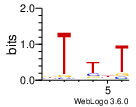

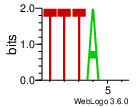

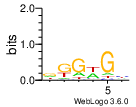

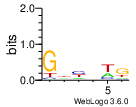

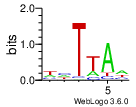

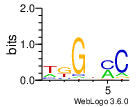

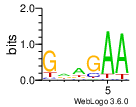

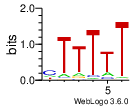

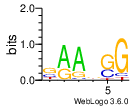

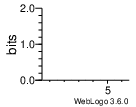

10_PARCLIP_ELAVL1A_hg19
([0, 4, 1, 8, 2, 6, 5, 7, 3, 9], array([0.88369037, 0.94640981, 0.9499475 , 0.95181187, 0.93675722,
       0.95059522, 0.95002637, 0.95066497, 0.94868784, 0.95263172]))


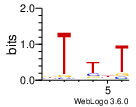

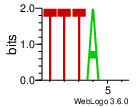

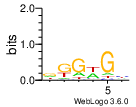

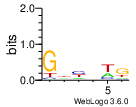

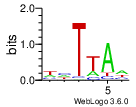

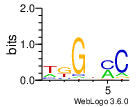

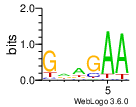

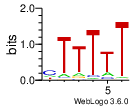

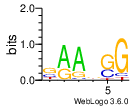

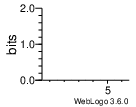

12_PARCLIP_EWSR1_hg19
([6, 9, 3, 0, 1, 5, 2, 4, 8, 7], array([0.95227547, 0.95806791, 0.96071412, 0.94707263, 0.96077512,
       0.95910681, 0.91466678, 0.96132681, 0.96081956, 0.94427522]))


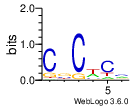

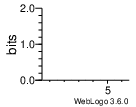

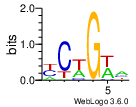

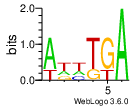

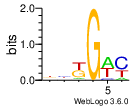

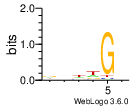

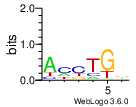

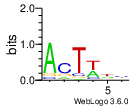

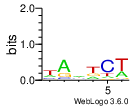

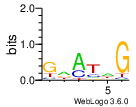

13_PARCLIP_FUS_hg19
([1, 8, 2, 9, 5, 0, 4, 7, 6, 3], array([0.93953797, 0.92090503, 0.93416437, 0.94488069, 0.94310791,
       0.93907756, 0.944296  , 0.94322869, 0.93244291, 0.93788722]))


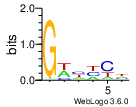

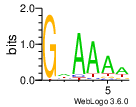

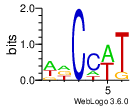

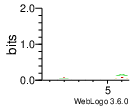

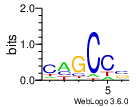

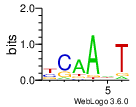

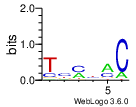

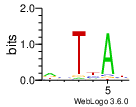

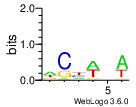

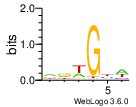

14_PARCLIP_FUS_mut_hg19
([6, 7, 5, 9, 2, 4, 1, 0, 3], array([0.99038859, 0.98951838, 0.98941625, 0.99041737, 0.98948394,
       0.98695338, 0.98372044, 0.98691809, 0.97996175, 0.98885081]))


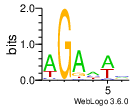

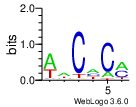

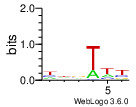

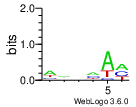

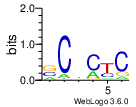

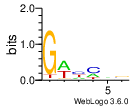

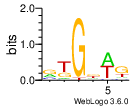

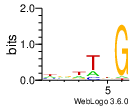

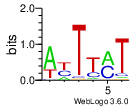

15_PARCLIP_IGF2BP123_hg19
([8, 0, 1, 5, 3, 2, 7, 6, 4, 9], array([0.947494  , 0.94871834, 0.95241178, 0.95012256, 0.95359872,
       0.94991287, 0.95301219, 0.95280516, 0.93786072, 0.95386394]))


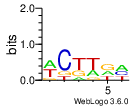

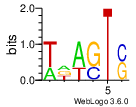

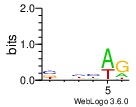

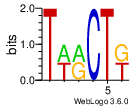

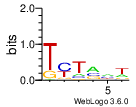

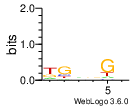

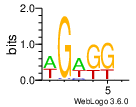

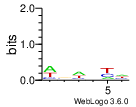

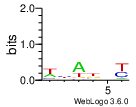

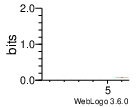

16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters
([4, 7, 1, 0, 9, 5, 8, 6, 3], array([0.95533847, 0.95401025, 0.92733466, 0.95743156, 0.89437688,
       0.95590741, 0.95704613, 0.94675612, 0.95633944, 0.95581575]))


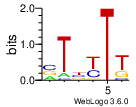

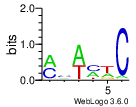

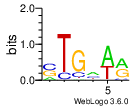

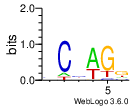

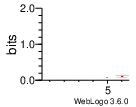

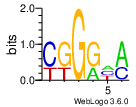

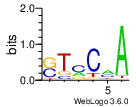

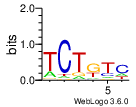

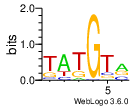

17_ICLIP_HNRNPC_hg19
([3, 9, 5, 2, 1, 0, 6, 8, 7, 4], array([0.9702755 , 0.96954319, 0.96619225, 0.87259697, 0.97134478,
       0.96465044, 0.97064363, 0.97114822, 0.97082228, 0.96447534]))


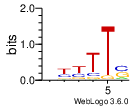

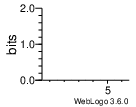

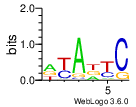

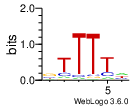

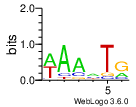

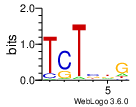

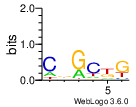

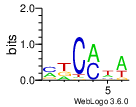

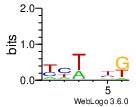

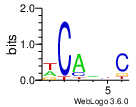

18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome
([0, 6, 9, 4, 2, 7, 8, 5, 3, 1], array([0.828162  , 0.85536466, 0.85410231, 0.85523447, 0.85346319,
       0.85504266, 0.838842  , 0.8546625 , 0.85503006, 0.84958022]))


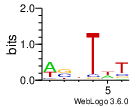

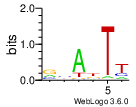

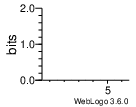

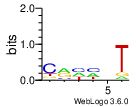

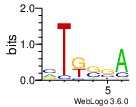

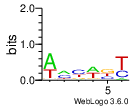

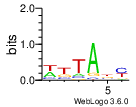

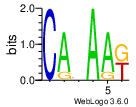

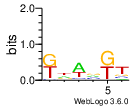

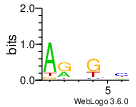

19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome
([0, 9, 5, 4, 3, 7, 2, 8, 1, 6], array([0.75193116, 0.78962853, 0.78848753, 0.78105625, 0.78063384,
       0.77990978, 0.78991028, 0.78791816, 0.78858156, 0.75485737]))


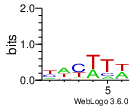

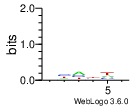

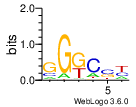

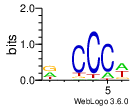

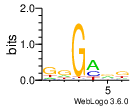

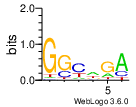

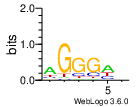

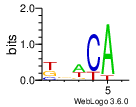

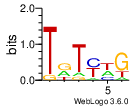

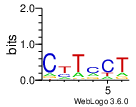

20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome
([9, 0, 5, 1, 6, 4, 3, 2, 7, 8], array([0.77588697, 0.78839069, 0.79155656, 0.79133919, 0.79038853,
       0.78693447, 0.78934162, 0.79168638, 0.79475684, 0.76645856]))


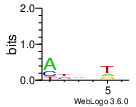

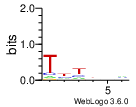

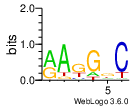

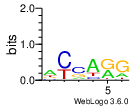

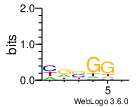

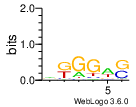

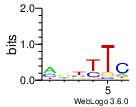

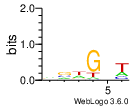

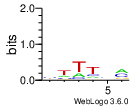

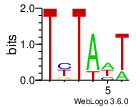

21_PARCLIP_MOV10_Sievers_hg19
([5, 8, 6, 0, 2, 3, 7, 4, 9], array([0.97593763, 0.97249691, 0.97623525, 0.97697722, 0.97728956,
       0.97402997, 0.97524719, 0.97705325, 0.97503041, 0.97744378]))


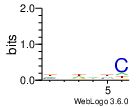

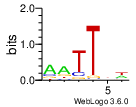

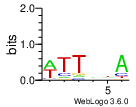

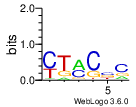

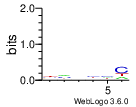

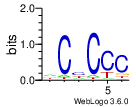

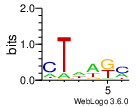

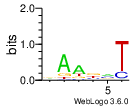

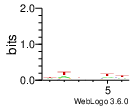

22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome
([4, 2, 7, 0, 5, 8, 3, 6, 1], array([0.85825406, 0.8661285 , 0.84130403, 0.86143037, 0.72370231,
       0.86089466, 0.86592212, 0.85699425, 0.8613945 , 0.77105588]))


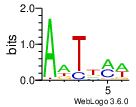

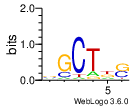

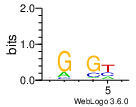

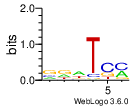

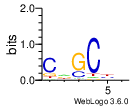

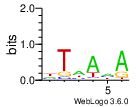

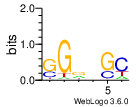

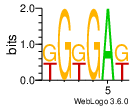

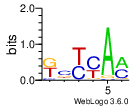

23_PARCLIP_PUM2_hg19
([5, 3, 9, 2, 0, 1, 4, 6, 8], array([0.98660275, 0.98695425, 0.98468641, 0.98202516, 0.98703388,
       0.97793156, 0.98744041, 0.98210153, 0.98814781, 0.98378122]))


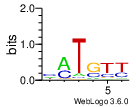

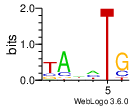

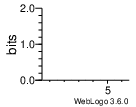

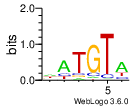

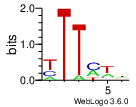

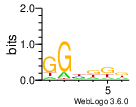

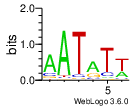

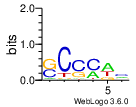

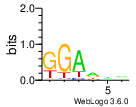

24_PARCLIP_QKI_hg19
([6, 1, 0, 8, 4, 7, 5, 2, 3, 9], array([0.97302113, 0.9625305 , 0.97511675, 0.97803506, 0.97368372,
       0.97453144, 0.96147859, 0.97415459, 0.97314122, 0.97811453]))


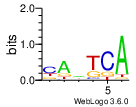

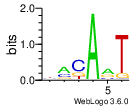

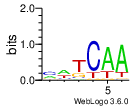

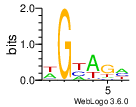

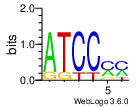

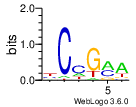

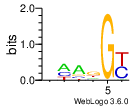

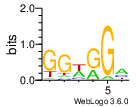

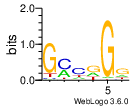

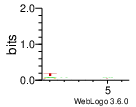

25_CLIPSEQ_SFRS1_hg19
([3, 0, 9, 4, 7, 2, 6, 5, 1], array([0.89210347, 0.92215291, 0.90109209, 0.89032937, 0.8985035 ,
       0.91277131, 0.90823738, 0.89946313, 0.90747513, 0.89415531]))


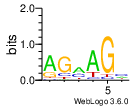

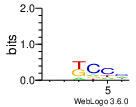

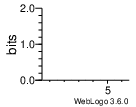

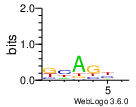

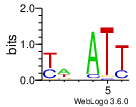

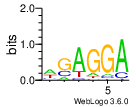

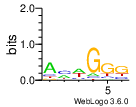

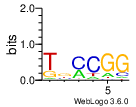

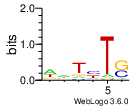

26_PARCLIP_TAF15_hg19
([1, 3, 0, 2, 9, 6, 7, 8, 5], array([0.96817475, 0.94865106, 0.96955691, 0.96549825, 0.97034428,
       0.97936984, 0.97661741, 0.97759334, 0.97765628, 0.97659491]))


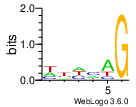

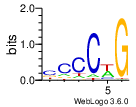

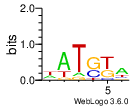

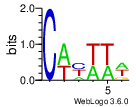

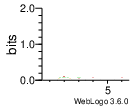

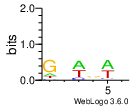

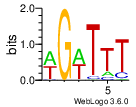

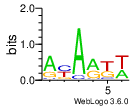

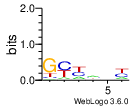

27_ICLIP_TDP43_hg19
([7, 4, 0, 8, 1, 3, 2, 5, 9, 6], array([0.89239563, 0.89570369, 0.90558419, 0.90241284, 0.88652297,
       0.90649378, 0.91068678, 0.84729578, 0.89379381, 0.90707013]))


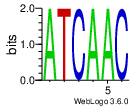

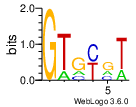

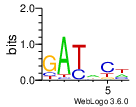

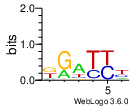

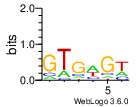

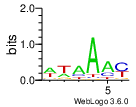

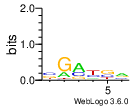

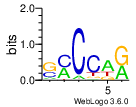

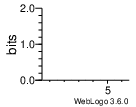

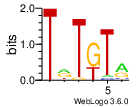

28_ICLIP_TIA1_hg19
([5, 2, 8, 0, 3, 7, 4, 9, 1, 6], array([0.95948263, 0.96998772, 0.95370306, 0.96321653, 0.96830112,
       0.91938916, 0.971735  , 0.96357503, 0.95825719, 0.96898253]))


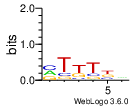

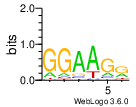

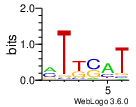

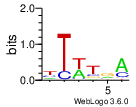

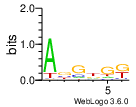

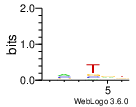

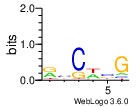

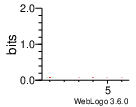

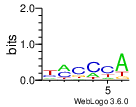

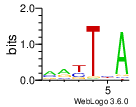

29_ICLIP_TIAL1_hg19
([8, 9, 5, 2, 0, 1, 7, 4, 6, 3], array([0.93120313, 0.93817556, 0.93033266, 0.94535747, 0.94162509,
       0.92870981, 0.94382547, 0.94034356, 0.78641841, 0.92479897]))


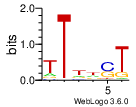

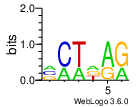

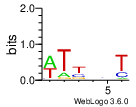

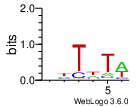

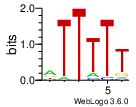

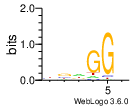

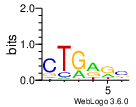

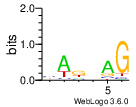

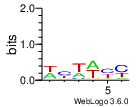

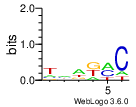

30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters
([1, 0, 2, 8, 5, 6, 9, 3, 7, 4], array([0.92076528, 0.90603297, 0.92605825, 0.94203094, 0.94237541,
       0.93335631, 0.93449481, 0.94231437, 0.92976803, 0.93677862]))


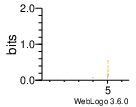

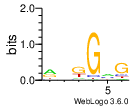

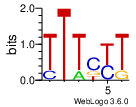

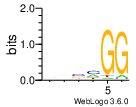

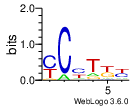

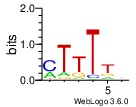

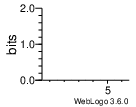

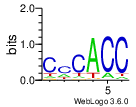

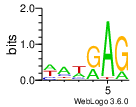

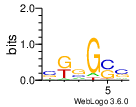

31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters
([7, 2, 4, 0, 6, 9, 1, 8, 3], array([0.93379103, 0.93576238, 0.92375463, 0.93903547, 0.93113512,
       0.88800834, 0.93514238, 0.92201222, 0.93755022, 0.93570706]))


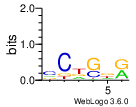

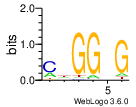

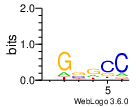

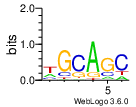

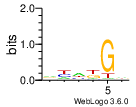

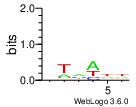

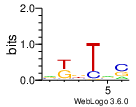

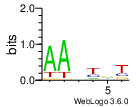

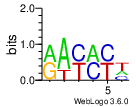

In [3]:
protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
training_set_number = 0
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']
for protein in protein_list:
    get_filter_motifs(protein, training_set_number, experiment_set)


In [10]:
import os
from IPython.display import display, Image
from keras.models import model_from_json
from scipy import ndimage
from Bio.Seq import Seq
from Bio import motifs
from Bio.Alphabet import IUPAC
# TESTING CELL


def set_model_filter(model, filter_number):
    filters, biases = model.layers[0].get_weights()
    zero_filter = np.zeros((filters.shape[0], filters.shape[1]))
    biases[filter_number] = 0
    filters[:, :, filter_number] = zero_filter
    model.layers[0].set_weights([filters, biases])
    return model


def get_filter_motifs(protein, training_set_number, experiment_set):
    # Predict binding without one filter and return ROC for each sample.
    filter_predictions = np.zeros((10, 10000))
    print(protein)
    
    
    def set_filter(protein, training_set_number, filter_number):
        #Set filter weigths to 0.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            original_model = model_from_json(json)
            original_model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
            model = set_model_filter(original_model, filter_number)
        return model
        

    def find_activation_max(protein, training_set_number, filter_predictions):
        # Find activation maximums of each filter for sequences were their activation was the highest.
        activation_max = []
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            original_model = model_from_json(json)
            original_model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
            filters, biases = model.layers[0].get_weights()
            for filter_number, x in zip(np.argmin(filter_predictions, axis=0), X_test):
                current_filter = filters[:, :, filter_number]
        #         print(current_filter.shape, x.shape)
                conv = np.zeros(x.shape)
                for row, (fil_row, x_row) in enumerate(zip(np.rollaxis(current_filter, 1), np.rollaxis(x, 1))):
        #             print(fil_row.shape, x_row.shape)
                    conv[:, row] = np.maximum(ndimage.convolve1d(x_row, weights=fil_row, mode="constant", origin=2), 0)
        #       print(conv.shape, conv[:, 35])
                activation_max.append(np.argmax(np.sum(conv, axis=1)))
        return activation_max


    def create_motiflogo(protein, training_set_number, filters_sequences, filter_predictions):
        for fil in filters_sequences.keys():
            cmd = ("weblogo -f filter_motifs/{1}/filter{0}_motif.txt -F png -o filter_motifs/{1}/motif{0}.png --errorbars NO --show-xaxis YES --show-yaxis YES -A dna --composition none --color '#00CC00' 'A' 'A' --color '#0000CC' 'C' 'C' --color '#FFB300' 'G' 'G' --color '#CC0000' 'T' 'T'".format(fil, protein))
            os.system(cmd)

        filter_nums, occurences = np.unique(np.argmin(filter_predictions, axis=0), return_counts=True)
        print(filter_nums, np.argsort(occurences))
        filter_nums = [filter_nums[i] for i in np.argsort(occurences)][::-1]
#         print(filter_nums)
        for fil in filter_nums:
            display(Image('filter_motifs/{1}/motif{0}.png'.format(fil, protein)))


    def create_filter_sequences(protein, training_set_number, filter_predictions, activation_max):
        if not os.path.exists('filter_motifs/{}'.format(protein)):
            os.mkdir('filter_motifs/{}'.format(protein))

        test_sequences = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
        filters_sequences = {}
        for record, filter_number, index_max in zip(SeqIO.parse(test_sequences,"fasta"), np.argmin(filter_predictions, axis=0), activation_max):
            sequence = list(record.seq)[index_max:index_max+6]
            while len(sequence) < 6:
                sequence.append("N")
            motif = Seq("".join(sequence))
        #     print(motif)
            if filter_number in filters_sequences:
                filters_sequences[filter_number].append(motif)
            else:
                filters_sequences[filter_number] = [motif]
#         print(filters_sequences.keys())
        # print(filters_sequences[0])
        for filter_number, fil_seq in filters_sequences.iteritems():
            with open("filter_motifs/{}/filter{}_motif.txt".format(protein, filter_number), "w") as motif_file:
                for motif in fil_seq:
                    motif_file.write(str(motif) + "\n")
        return filters_sequences


    for filter_num in range(10):
            model = set_filter(protein, training_set_number, filter_num)
            #Load data for testing purposes.
            data_sources, X_test = load_data_sources(protein, 'test', training_set_number, *experiment_set)

            #Run predictions on test dataset and save them.
            predictions = model.predict(X_test)
            y_scores = predictions [:,0:1]
            filter_predictions[filter_num] = y_scores.flatten()
#             y_test = get_class(protein,"test",training_set_number)
#             y_test = y_test [:,0:1]

#             score = roc_auc_score(y_test, y_scores)
#             fpr, tpr, thresholds = roc_curve(y_test, y_scores)
#             plt.plot(fpr, tpr, label="ROC of set {}".format(training_set_number))
#             plt.plot([0, 1], [0, 1], 'k--')
#             plt.xlabel('False positive rate')
#             plt.ylabel('True positive rate')
#             plt.title('ROC curves of %s' %protein)
#             plt.legend(loc='best')
#             plt.show()


#             print(np.mean(score))

    activation_max = find_activation_max(protein, training_set_number, filter_predictions)
    filter_sequences = create_filter_sequences(protein, training_set_number, filter_predictions, activation_max)
    create_motiflogo(protein, training_set_number, filter_sequences, filter_predictions)




1_PARCLIP_AGO1234_hg19
([6, 1, 9, 8, 7, 4, 0, 3, 2], array([0.93509841, 0.88179191, 0.93643897, 0.93551856, 0.93376519,
       0.92278041, 0.8484365 , 0.93362947, 0.93008719, 0.91783212]))


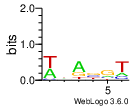

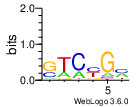

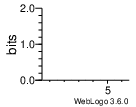

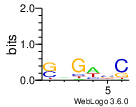

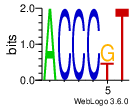

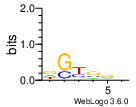

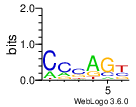

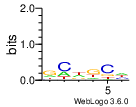

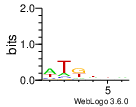

In [11]:
protein_list = ["1_PARCLIP_AGO1234_hg19"]#, "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
training_set_number = 0
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']
for protein in protein_list:
    get_filter_motifs(protein, training_set_number, experiment_set)


In [11]:
from scipy import ndimage

def find_activation_max():
    # Find activation maximums of each filter for sequences were their activation was the highest.
    activation_max = []
    with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
        json = json_file.read()
        original_model = model_from_json(json)
        original_model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
        filters, biases = model.layers[0].get_weights()
        for filter_number, x in zip(np.argmin(filter_predictions, axis=0), X_test):
            current_filter = filters[:, :, filter_number]
    #         print(current_filter.shape, x.shape)
            conv = np.zeros(x.shape)
            for row, (fil_row, x_row) in enumerate(zip(np.rollaxis(current_filter, 1), np.rollaxis(x, 1))):
    #             print(fil_row.shape, x_row.shape)
                conv[:, row] = np.maximum(ndimage.convolve1d(x_row, weights=fil_row, mode="constant", origin=2), 0)
    #       print(conv.shape, conv[:, 35])
            activation_max.append(np.argmax(np.sum(conv, axis=1)))
    return find_activation_max()

    


(10000, 101, 36)
[19, 93, 68, 45, 78, 50, 51, 47, 9, 78, 82, 63, 61, 78, 96, 72, 87, 67, 41, 58, 67, 93, 84, 20, 46, 11, 51, 40, 49, 19, 43, 81, 7, 67, 11, 84, 31, 85, 17, 36, 39, 48, 80, 60, 62, 27, 14, 31, 86, 17, 5, 59, 89, 35, 0, 14, 23, 70, 53, 4, 15, 40, 66, 92, 10, 32, 86, 50, 55, 36, 42, 5, 15, 16, 19, 69, 3, 27, 25, 32, 94, 3, 63, 71, 94, 44, 46, 0, 90, 35, 47, 17, 75, 25, 83, 16, 9, 13, 47, 42, 78, 36, 21, 0, 0, 92, 0, 88, 64, 82, 53, 87, 9, 64, 40, 96, 15, 55, 94, 96, 72, 60, 27, 83, 13, 42, 38, 29, 41, 49, 8, 46, 18, 66, 4, 83, 86, 20, 79, 38, 58, 1, 13, 60, 12, 74, 28, 50, 30, 69, 66, 57, 77, 6, 90, 39, 46, 80, 90, 79, 65, 17, 20, 55, 46, 35, 6, 85, 20, 53, 54, 64, 90, 53, 9, 73, 43, 77, 50, 59, 33, 8, 32, 1, 78, 58, 0, 47, 38, 41, 94, 39, 73, 50, 70, 56, 0, 95, 8, 72, 5, 74, 41, 0, 29, 37, 45, 28, 96, 23, 91, 88, 91, 72, 81, 72, 17, 42, 18, 92, 87, 26, 81, 70, 92, 36, 21, 90, 88, 78, 4, 31, 42, 16, 14, 50, 17, 71, 84, 88, 42, 20, 0, 7, 14, 37, 20, 21, 16, 18, 56, 29, 6, 3

In [66]:
print(ndimage.convolve1d(np.ones(101), weights=np.ones(6), mode="constant", origin=2))

[6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 5. 4. 3. 2. 1.]


In [12]:
from Bio.Seq import Seq
from Bio import motifs
from Bio.Alphabet import IUPAC
test_sequences = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
filters_sequences = {}
for record, filter_number, index_max in zip(SeqIO.parse(test_sequences,"fasta"), np.argmin(filter_predictions, axis=0), activation_max):
    sequence = list(record.seq)[index_max:index_max+6]
    while len(sequence) < 6:
        sequence.append("N")
    motif = Seq("".join(sequence))
#     print(motif)
    if filter_number in filters_sequences:
        filters_sequences[filter_number].append(motif)
    else:
        filters_sequences[filter_number] = [motif]
print(filters_sequences.keys())
# print(filters_sequences[0])
for filter_number, fil_seq in filters_sequences.iteritems():
    with open("filter{}_motif.txt".format(filter_number), "w") as motif_file:
        for motif in fil_seq:
            motif_file.write(str(motif) + "\n")
# print(IUPAC.ambiguous_dna.letters)
# m = motifs.create(filters_sequences[0], IUPAC.ambiguous_dna)
# m.weblogo("motif_test.png", show_fineprint=False, color_scheme="color_classic", stack_width="large")


[0, 1, 2, 3, 4, 6, 7, 8, 9]


([0, 1, 2, 3, 4, 6, 7, 8, 9], array([6, 5, 4, 3, 8, 2, 0, 7, 1]))
[1, 8, 0, 2, 9, 3, 4, 6, 7]


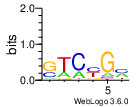

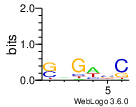

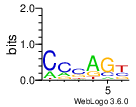

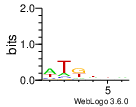

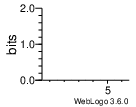

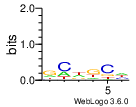

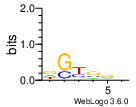

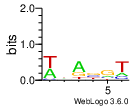

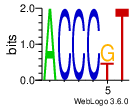

In [20]:
import os
from IPython.display import display, Image
for i in filters_sequences.keys():
    with open("filter_motif.txt", "w") as motif_file:
        for motif in filters_sequences[i]:
            motif_file.write(str(motif) + "\n")
    cmd = ("weblogo -f filter{0}_motif.txt -F png -o motif{0}_test.png --errorbars NO --show-xaxis YES --show-yaxis YES -A dna --composition none --color '#00CC00' 'A' 'A' --color '#0000CC' 'C' 'C' --color '#FFB300' 'G' 'G' --color '#CC0000' 'T' 'T'".format(i))
    os.system(cmd)
occurences = [ 671, 6583,  408,   91,   58,   54,    2, 1838,  295]
filter_nums = [0, 1, 2, 3, 4, 6, 7, 8, 9]
print(filter_nums, np.argsort(occurences))
filter_nums = [filter_nums[i] for i in np.argsort(occurences)][::-1]
print(filter_nums)
for fil in filter_nums:
    display(Image('motif{}_test.png'.format(fil)))

In [18]:
from keras.models import model_from_json
from IPython.display import display, Image
from Bio import motifs

            
'''
 RNA : probability of double stranded structure
 RG :exon, intron, 5’UTR, 3’UTR, CDS
 KMER : A, U, G, C
 CLIP 
'''
# jaspar_file = open("test.dat", "w")
# protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
# experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']
# d_source = "KMER"
# for training_set_number in range (1):
#     for protein in protein_list:
#         print (protein)
        
#         #Load the model and weights.
#         with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
#             json = json_file.read()
#             model = model_from_json(json)
#             model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
#             filters, biases = model.layers[0].get_weights()
            
#             filter_min, filter_max = filters.min(), filters.max()
#             #normalize filter values
#             filters = (filters - filter_min) / (filter_max - filter_min)
            
#             nucleotides = {0 : "A", 1 : "T", 2 : "G", 3 : "C"}
#             d_sources_filters = {'KMER': filters[:, 0:4 , :], 'RNA': filters[:, 4:5 , :], 'RG': filters[:, 5:10 , :], 'CLIP': filters[:, 10:36 , :]}
#             for filter_num in xrange(10):
#                     fil = (d_sources_filters["KMER"])[:,:,filter_num]
# #                     print(fil.T)
#                     jaspar_file.writelines(">filter " + "{}_{}_{}".format(d_source, protein, filter_num) + "\n")
#                     for i, nucleotide in enumerate(fil.T):
#                         jaspar_file.writelines(nucleotides[i] + " [ " + " ".join(map(str, list(nucleotide))) + " ]\n")
# jaspar_file.close()
with open("test.dat", "r") as handle:
    record = motifs.parse(handle, "jaspar")
    for motif in record:
        print(motif.name)
        motif.weblogo("filters_png/{}.png".format(motif.name), unit_name="probability", show_xaxis=False, show_yaxis=False, show_fineprint=False, color_scheme="color_classic", stack_width="large")

KMER_1_PARCLIP_AGO1234_hg19_0
KMER_1_PARCLIP_AGO1234_hg19_1
KMER_1_PARCLIP_AGO1234_hg19_2
KMER_1_PARCLIP_AGO1234_hg19_3
KMER_1_PARCLIP_AGO1234_hg19_4
KMER_1_PARCLIP_AGO1234_hg19_5
KMER_1_PARCLIP_AGO1234_hg19_6
KMER_1_PARCLIP_AGO1234_hg19_7
KMER_1_PARCLIP_AGO1234_hg19_8
KMER_1_PARCLIP_AGO1234_hg19_9
KMER_2_PARCLIP_AGO2MNASE_hg19_0
KMER_2_PARCLIP_AGO2MNASE_hg19_1
KMER_2_PARCLIP_AGO2MNASE_hg19_2
KMER_2_PARCLIP_AGO2MNASE_hg19_3
KMER_2_PARCLIP_AGO2MNASE_hg19_4
KMER_2_PARCLIP_AGO2MNASE_hg19_5
KMER_2_PARCLIP_AGO2MNASE_hg19_6
KMER_2_PARCLIP_AGO2MNASE_hg19_7
KMER_2_PARCLIP_AGO2MNASE_hg19_8
KMER_2_PARCLIP_AGO2MNASE_hg19_9
KMER_3_HITSCLIP_Ago2_binding_clusters_0
KMER_3_HITSCLIP_Ago2_binding_clusters_1
KMER_3_HITSCLIP_Ago2_binding_clusters_2
KMER_3_HITSCLIP_Ago2_binding_clusters_3
KMER_3_HITSCLIP_Ago2_binding_clusters_4
KMER_3_HITSCLIP_Ago2_binding_clusters_5
KMER_3_HITSCLIP_Ago2_binding_clusters_6
KMER_3_HITSCLIP_Ago2_binding_clusters_7
KMER_3_HITSCLIP_Ago2_binding_clusters_8
KMER_3_HITSCLIP_Ago2

KMER_20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome_2
KMER_20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome_3
KMER_20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome_4
KMER_20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome_5
KMER_20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome_6
KMER_20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome_7
KMER_20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome_8
KMER_20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_

1_PARCLIP_AGO1234_hg19
RNA
0
1
2
3
4
5
6
7
8
9
RG
0
1
2
3
4
5
6
7
8
9
KMER
0
1
2
3
4
5
6
7
8
9
CLIP
0
1
2
3
4
5
6
7
8
9
2_PARCLIP_AGO2MNASE_hg19
RNA
0
1
2
3
4
5
6
7
8
9
RG
0
1
2
3
4
5
6
7
8
9
KMER
0
1
2
3
4
5
6
7
8
9
CLIP
0
1
2
3
4
5
6
7
8
9
3_HITSCLIP_Ago2_binding_clusters
RNA
0
1
2
3
4
5
6
7
8
9
RG
0
1
2
3
4
5
6
7
8
9
KMER
0
1
2
3
4
5
6
7
8
9
CLIP
0
1
2
3
4
5
6
7
8
9
4_HITSCLIP_Ago2_binding_clusters_2
RNA
0
1
2
3
4
5
6
7
8
9
RG
0
1
2
3
4
5
6
7
8
9
KMER
0
1
2
3
4
5
6
7
8
9
CLIP
0
1
2
3
4
5
6
7
8
9
5_CLIPSEQ_AGO2_hg19
RNA
0
1
2
3
4
5
6
7
8
9
RG
0
1
2
3
4
5
6
7
8
9
KMER
0
1
2
3
4
5
6
7
8
9
CLIP
0
1
2
3
4
5
6
7
8
9
6_CLIP-seq-eIF4AIII_1
RNA
0
1
2
3
4
5
6
7
8
9
RG
0
1
2
3
4
5
6
7
8
9
KMER
0
1
2
3
4
5
6
7
8
9
CLIP
0
1
2
3
4
5
6
7
8
9
7_CLIP-seq-eIF4AIII_2
RNA
0
1
2
3
4
5
6
7
8
9
RG
0
1
2
3
4
5
6
7
8
9
KMER
0
1
2
3
4
5
6
7
8
9
CLIP
0
1
2
3
4
5
6
7
8
9
8_PARCLIP_ELAVL1_hg19
RNA
0
1
2
3
4
5
6
7
8
9
RG
0
1
2
3
4
5
6
7
8
9
KMER
0
1
2
3
4
5
6
7
8
9
CLIP
0
1
2
3
4
5
6
7
8
9
9_PARCLIP_ELAVL1MNASE_

'\n RNA : probability of double stranded structure\n RG :exon, intron, 5\xe2\x80\x99UTR, 3\xe2\x80\x99UTR, CDS\n KMER : A, U, G, C\n CLIP \n'

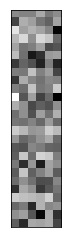

In [2]:
from keras.models import model_from_json
from IPython.display import display, Image


protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
            filters, biases = model.layers[0].get_weights()
            
            filter_min, filter_max = filters.min(), filters.max()
            #normalize filter values
            filters = (filters - filter_min) / (filter_max - filter_min)
            
            
            d_sources_filters = {'KMER': filters[:, 0:4 , :], 'RNA': filters[:, 4:5 , :], 'RG': filters[:, 5:10 , :], 'CLIP': filters[:, 10:36 , :]}
            
            
            for d_source in d_sources_filters.keys():
                print (d_source)
#                 os.mkdir("filters_png/{}".format(d_source))
#                 fig, axs = plt.subplots(nrows = 6, ncols = 1, 
#                                             subplot_kw={'xticks': [], 'yticks': []})
                for filter_num in xrange(10):
                        fil = (d_sources_filters[d_source])[:,:,filter_num]
                        plt.xticks([])
                        plt.yticks([])
                        plt.imshow(fil.T, cmap='binary')
                        print(filter_num)
                        # ax.set_title(filter_num+1)
                        plt.savefig("filters_png/{}/{}_{}.png".format(d_source, protein, filter_num),
                                    bbox_inches = 'tight',
                                    pad_inches = 0)
            
            
'''
 RNA : probability of double stranded structure
 RG :exon, intron, 5’UTR, 3’UTR, CDS
 KMER : A, U, G, C
 CLIP 
'''


1_PARCLIP_AGO1234_hg19
('RNA', (6, 1, 60))
(60, 6)


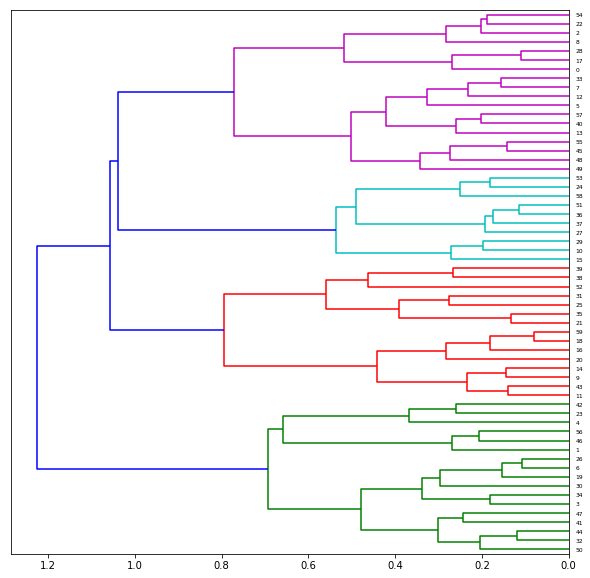

0.4153524657740263
('RG', (6, 5, 60))
(60, 30)


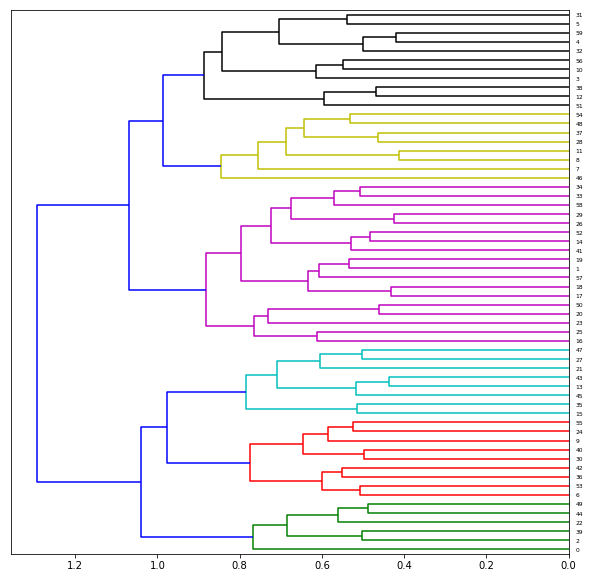

0.3345435502564731
('KMER', (6, 4, 60))
(60, 24)


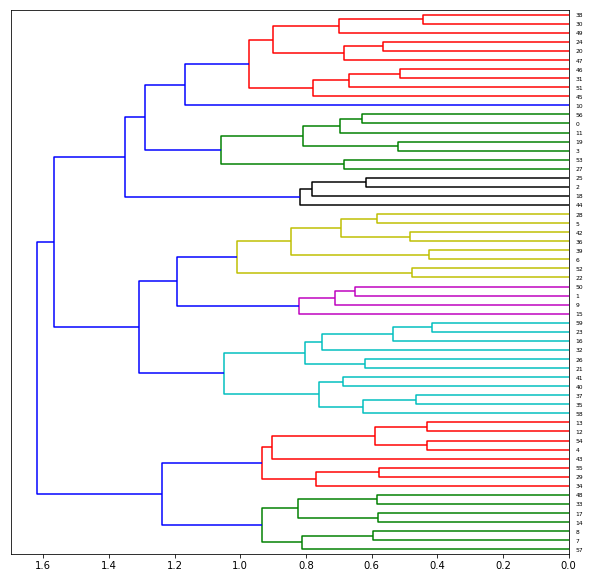

0.3467674318800691
('CLIP', (6, 26, 60))
(60, 156)


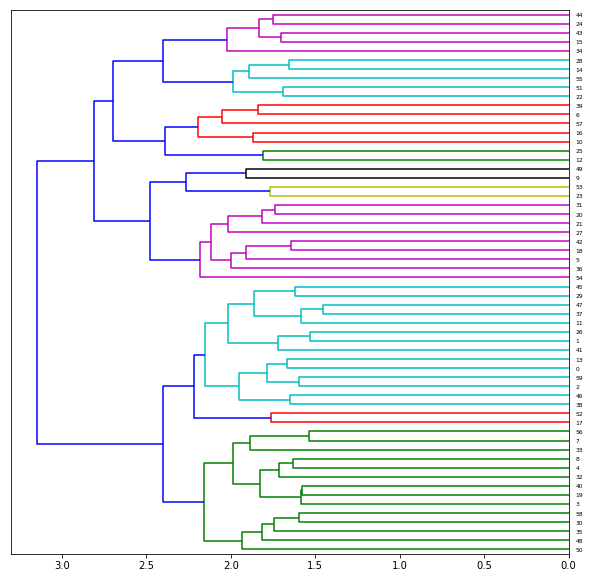

0.40949842508032236


In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from keras.models import model_from_json
import numpy as np
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

protein_list = ["1_PARCLIP_AGO1234_hg19"]#, "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
            filters, biases = model.layers[0].get_weights()
            
            filter_min, filter_max = filters.min(), filters.max()
            #normalize filter values
            filters = (filters - filter_min) / (filter_max - filter_min)
            
            
            d_sources_filters = {'KMER': filters[:, 0:4 , :], 'RNA': filters[:, 4:5 , :], 'RG': filters[:, 5:10 , :], 'CLIP': filters[:, 10:36 , :]}
            
            
            for d_source in d_sources_filters.keys():
                print (d_source, d_sources_filters[d_source].shape) 
                #Create a array of observation vectors with dimensions [filter_number, flattened_filter]
                flat_source_arr = np.transpose(d_sources_filters[d_source].reshape(-1,d_sources_filters[d_source].shape[-1]))
                print (flat_source_arr.shape)
                Z = linkage(flat_source_arr, 'ward')
                fig = plt.figure(figsize=(10, 10))
                dn = dendrogram(Z, orientation = 'left')
                plt.show()
                
                
                #Calculate cophenetic correlation.
                c, coph_dists = cophenet(Z, pdist(flat_source_arr))
                print (c)

In [ ]:
import os
from IPython.display import display, Image

cmd = ("weblogo -f test.txt -D transfac -F png -o test.png --errorbars NO --show-xaxis YES --show-yaxis YES -U probability -A dna --composition none --color '#00CC00' 'A' 'A' --color '#0000CC' 'C' 'C' --color '#FFB300' 'G' 'G' --color '#CC0000' 'T' 'T'") 
os.system(cmd)
display(Image('test.png'))

8_PARCLIP_ELAVL1_hg19
('RNA', (6, 1, 60))
(60, 6)
('RG', (6, 5, 60))
(60, 30)
('KMER', (6, 4, 60))
(60, 24)
('CLIP', (6, 26, 60))
(60, 156)


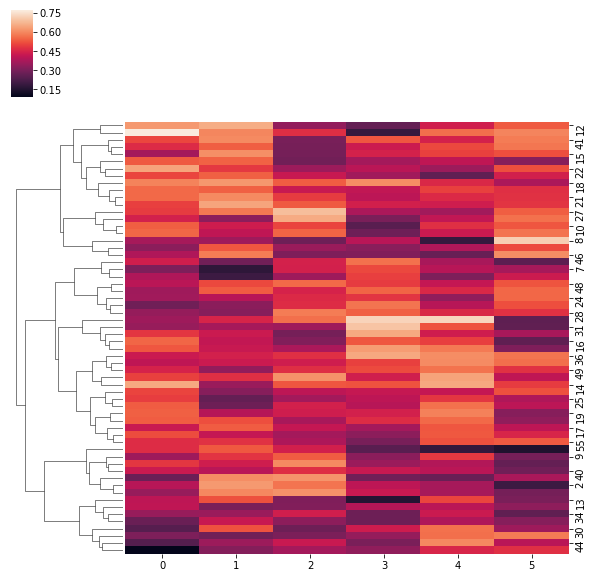

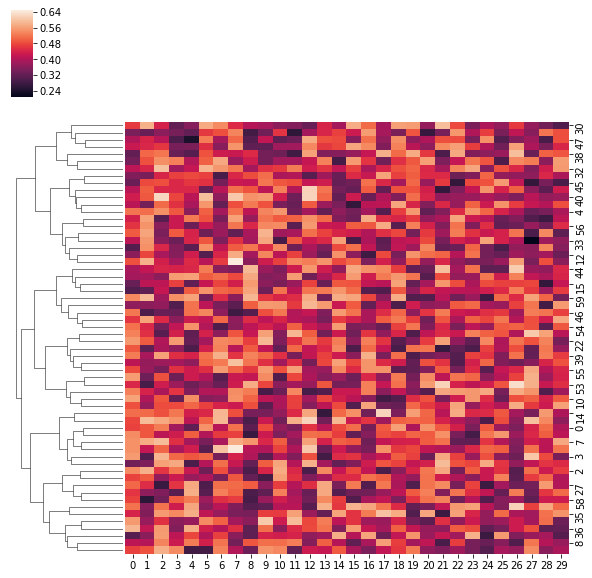

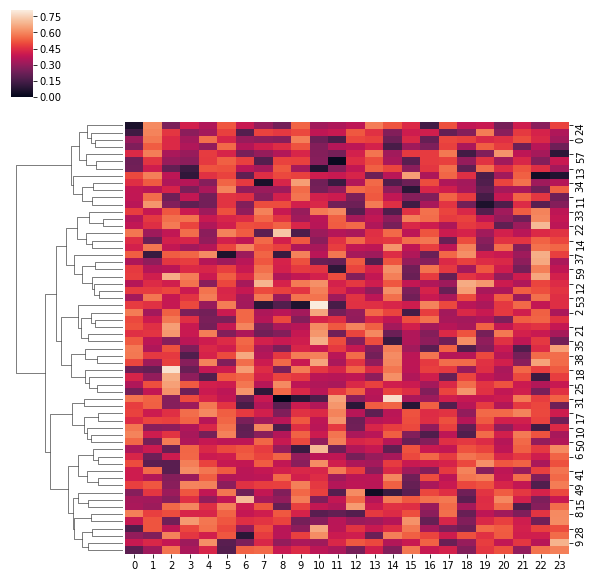

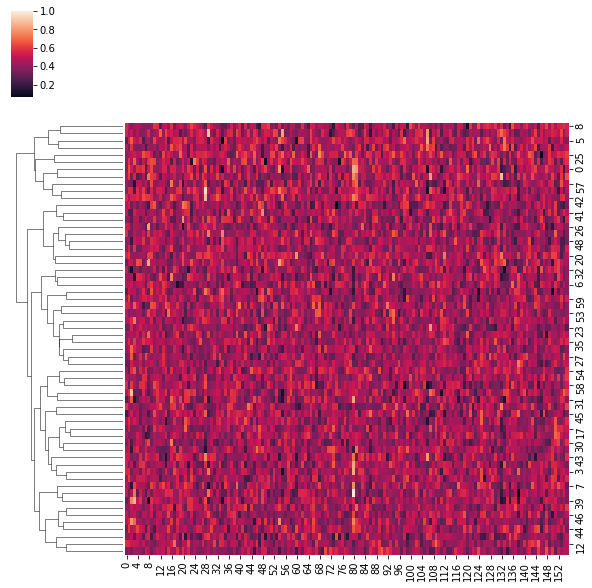

In [4]:
#installed seaborn
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from keras.models import model_from_json
import numpy as np
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

protein_list = ["8_PARCLIP_ELAVL1_hg19"]#["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
            filters, biases = model.layers[0].get_weights()
            
            filter_min, filter_max = filters.min(), filters.max()
            #normalize filter values
            filters = (filters - filter_min) / (filter_max - filter_min)
            
            
            d_sources_filters = {'KMER': filters[:, 0:4 , :], 'RNA': filters[:, 4:5 , :], 'RG': filters[:, 5:10 , :], 'CLIP': filters[:, 10:36 , :]}
            
            for d_source in d_sources_filters.keys():
                print (d_source, d_sources_filters[d_source].shape) 
                #Create a array of observation vectors with dimensions [filter_number, flattened_filter]
                flat_source_arr = np.transpose(d_sources_filters[d_source].reshape(-1,d_sources_filters[d_source].shape[-1]))
                print (flat_source_arr.shape)
                g = sns.clustermap(flat_source_arr, method = 'ward', col_cluster = False)

17_ICLIP_HNRNPC_hg19
(30000, 101, 39)
0.972461375
RNA
('RNA', (6, 1, 10))
(10, 6)


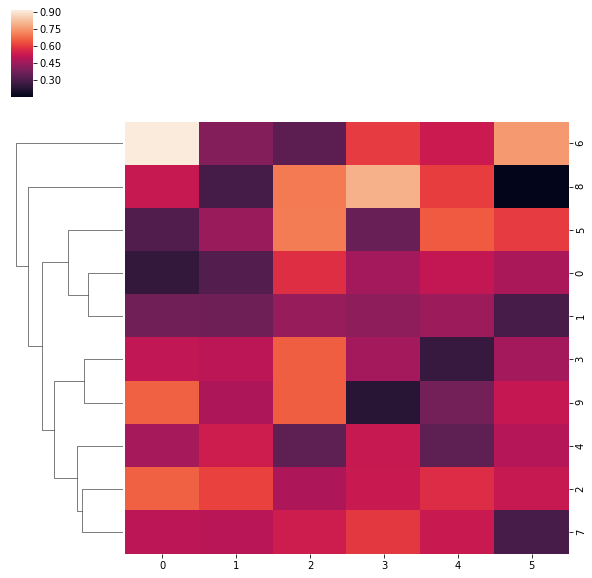

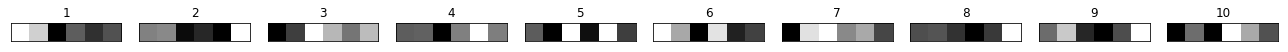

RG
('RG', (6, 5, 10))
(10, 30)


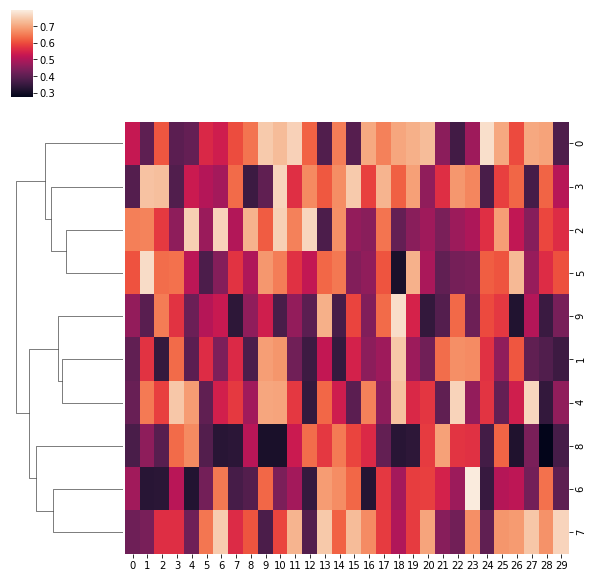

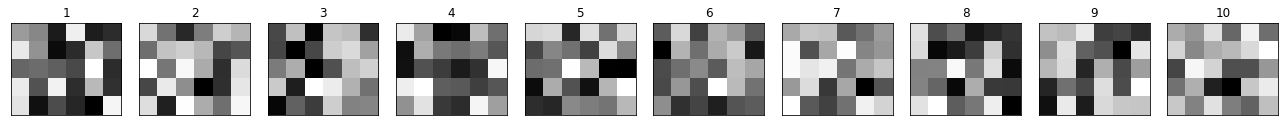

KMER
('KMER', (6, 4, 10))
(10, 24)


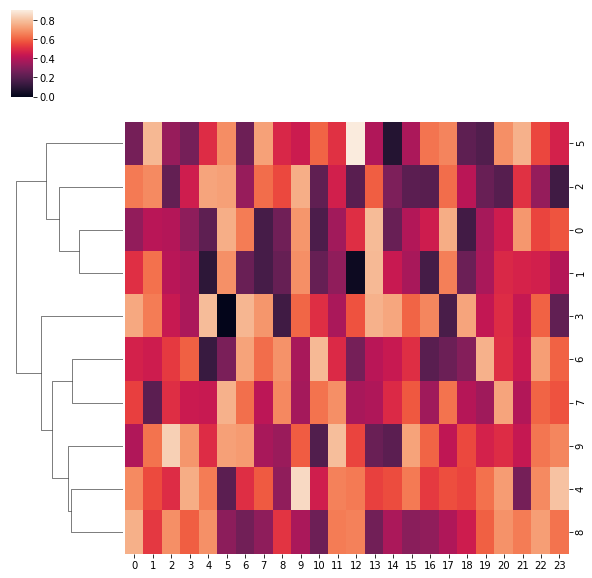

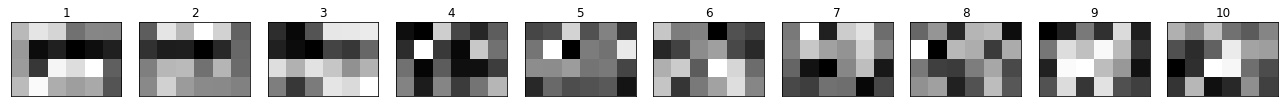

CLIP
('CLIP', (6, 26, 10))
(10, 156)


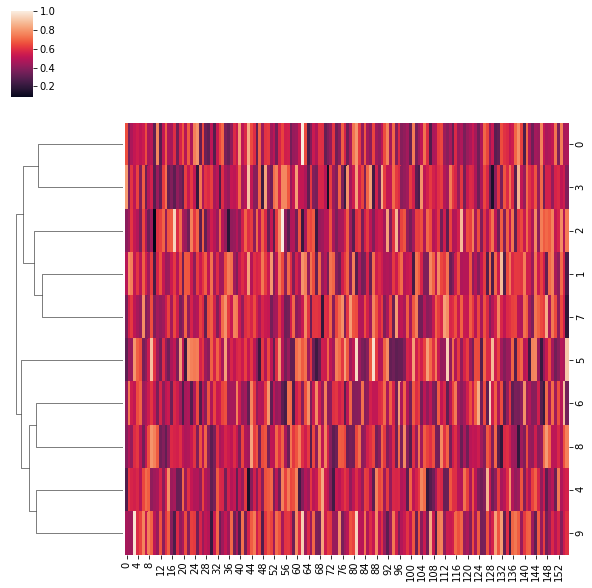

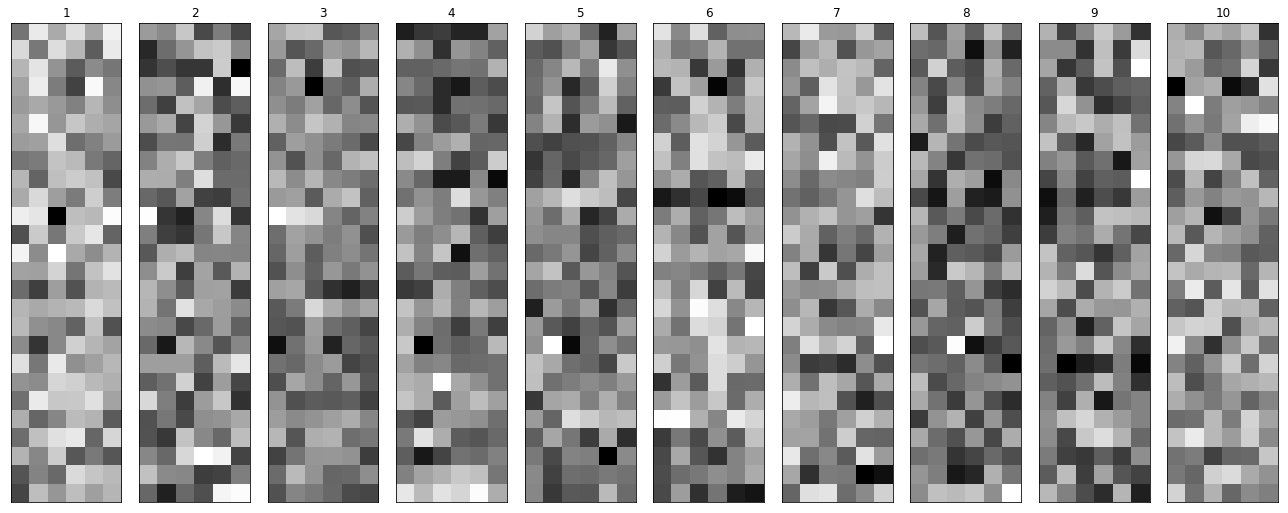

In [2]:
#30k datasets 
%matplotlib inline 

import numpy as np
from Bio import SeqIO
import gzip
import os
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



np.random.seed(454)


def load_data(path):   
    data = gzip.open(os.path.join(path,"sequences.fa.gz"),"rt")
    return data


def get_seq(protein, t_data, training_set_number): 
    if t_data == "train":
                
        training_data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((30000,101,4))          
    
    elif t_data == "test":    
                
        training_data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((10000,101,4))      
      
    r = 0    
      
    
    for record in SeqIO.parse(training_data,"fasta"):
        sequence = list(record.seq)                
        nucleotide = {'A' : 0, 'T' : 1, 'G' : 2, 'C' : 3, 'N' : 4} 
        num_seq = list() #sekvenca v številskem formatu


        for i in range(0,len(sequence)):
                num_seq.append(nucleotide[sequence[i]])


        X = np.zeros((1,len(num_seq),4))

        
        for i in range (len(num_seq)):
                if num_seq[i] <= 3:
                    X[:,i,num_seq[i]] = 1               

        x_train[r,:,:] = X
        r = r + 1
    
    return x_train


def get_class(protein, t_data,training_set_number):
    y_train = []
    

    if t_data == 'train':
        data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))

    elif t_data == 'test':
        data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))


    for record in SeqIO.parse(data,"fasta"):
        v = int((record.description).split(":")[1])
        # [1,0] if there was no observed binding and [0,1] for sequences where binding was observed.
        y_train.append([int(v == 0), int(v != 0)])

    y_train = np.array(y_train)
    return y_train


def get_cobinding(protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
            
        cobinding = np.zeros((30000,101,cobinding_data.shape[1]/101),dtype=np.int)    
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
        cobinding = np.zeros((10000,101,cobinding_data.shape[1]/101),dtype=np.int)
   
    
    for n in range(0,cobinding_data.shape[1],101):
        a = cobinding_data[:,n:(n+101)]
        cobinding[:,:,(n/101)] = a
    
    return cobinding
    

def get_region (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1)
        region = np.zeros((30000,101,region_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1) 
        region = np.zeros((10000,101,region_data.shape[1]/101),dtype=np.int)
    

    for n in range(0,region_data.shape[1],101):
        a = region_data[:,n:(n+101)]
        region[:,:,(n/101)] = a
        
    return region


def get_fold (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((30000,101,fold_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((10000,101,fold_data.shape[1]/101),dtype=np.int)




    for n in range(0,fold_data.shape[1],101):
        a = fold_data[:,n:(n+101)]
        fold[:,:,(n/101)] = a
    
    
    return fold

def load_data_sources(protein, t_data, training_set_number, *args):
    X = np.array([])
    data_sources = []
    for arg in args:
        
        if arg == 'KMER':
            if X.size == 0:
                X = get_seq(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_seq(protein, t_data, training_set_number)))
        if arg == 'RNA': 
            if X.size == 0:
                X = get_fold(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_fold(protein, t_data, training_set_number)))
        if arg == 'RG':   
            if X.size == 0:
                X = get_region(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_region(protein, t_data, training_set_number)))
        if arg == 'CLIP': 
            if X.size == 0:
                X = get_cobinding(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_cobinding(protein, t_data, training_set_number)))
        data_sources.append(arg)
        
    data_sources = ','.join(data_sources)
    return data_sources, X




protein_list =["17_ICLIP_HNRNPC_hg19"] #["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19"]#, "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
average_score = np.zeros(len(protein_list))
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']


for training_set_number in range (1):
        
    score_list = []
    
    for protein in protein_list:

        print (protein)

        data_sources, X = load_data_sources(protein, 'train', training_set_number, *experiment_set)
        y = get_class(protein,"train",training_set_number)
        print (X.shape)
        size = X.shape[2]
        score = []
        
        model = Sequential()
        model.add(Conv1D(10,6, data_format='channels_last', input_shape=(101, size) , strides = 1, padding='valid'))
        model.add(MaxPooling1D(pool_size=20, strides=1, padding='valid'))
        model.add(Conv1D(10, 4, activation='relu'))
        model.add(Dropout(0.1))
        model.add(MaxPooling1D(pool_size=40, strides=1, padding='valid'))
        model.add(Conv1D(15, 4, activation='relu'))
        model.add(MaxPooling1D(pool_size=30, strides=1, padding='valid'))
        model.add(Conv1D(15, 3, activation='relu'))
        model.add(GlobalAveragePooling1D())
        model.add(Dense(200, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(2, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        checkpointer = ModelCheckpoint(filepath="models/" + protein + "_weights.hdf5", verbose=0, save_best_only=True)
        earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

        X_train = X
        y_train = y

        metrics = model.fit(X_train, y_train, validation_split = 0.2, epochs=12, batch_size=200, verbose=0, callbacks=[earlystopper])

        
        #Load data for testing purposes.
        data_sources, X_test = load_data_sources(protein, 'test', training_set_number, *experiment_set)
        y_test = get_class(protein,"test",training_set_number)
        
        #Run predictions on test dataset.
        y_scores = model.predict(X_test)
        y_scores = y_scores [:,0:1]
        y_test = y_test [:,0:1]

        score = roc_auc_score(y_test, y_scores)
        print (score)

        filters, biases = model.layers[0].get_weights()
            
        filter_min, filter_max = filters.min(), filters.max()
        #normalize filter values
        filters = (filters - filter_min) / (filter_max - filter_min)


        d_sources_filters = {'KMER': filters[:, 0:4 , :], 'RNA': filters[:, 4:5 , :], 'RG': filters[:, 5:10 , :], 'CLIP': filters[:, 10:36 , :]}


        for d_source in d_sources_filters.keys():
            print (d_source)
            
            print (d_source, d_sources_filters[d_source].shape) 
            #Create a array of observation vectors with dimensions [filter_number, flattened_filter]
            flat_source_arr = np.transpose(d_sources_filters[d_source].reshape(-1,d_sources_filters[d_source].shape[-1]))
            print (flat_source_arr.shape)
            g = sns.clustermap(flat_source_arr, method = 'ward', col_cluster = False)
            
            fig, axs = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 10),
                                        subplot_kw={'xticks': [], 'yticks': []})
            for ax, filter_num in zip(axs.flat, xrange(10)):
                    fil = (d_sources_filters[d_source])[:,:,filter_num]
                    ax.imshow(fil.T, cmap='binary')
                    ax.set_title(filter_num+1)

            plt.tight_layout()
            plt.show()
        plt.close()

In [ ]:
%matplotlib inline 

from keras.models import model_from_json
from keras import activations
from vis.visualization import visualize_activation
from vis.utils import utils


experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']
training_set_number = 0
protein = "1_PARCLIP_AGO1234_hg19"

with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
            filters, biases = model.layers[0].get_weights()
            
            print (model.layers[0], filters.shape)
            
            layer_index = 0
            
            model.layers[layer_index].activation = activations.linear
            model = utils.apply_modifications(model)
            
            for i in xrange(filters.shape[2]):
                print (i)
                activation = visualize_activation(model, layer_index, filter_indices = i ,input_range = (0,2))
                plt.imshow(activation[:,0:4,:])
                plt.show()

In [39]:
from keras import models
def get_positive_samples(protein, t_data, training_set_number, *args ):
    data_sources, X_test = load_data_sources(protein, t_data, training_set_number, *args)
    y_test = get_class(protein, t_data, training_set_number)
    y_test = y_test [:,1]
    positive_samples = np.zeros((2000, X_test.shape[1], X_test.shape[2]))
    n = 0

    for i, value in enumerate(y_test):
        if value == 1:
            positive_samples[n] = X_test[i]
            n += 1 
 
    return positive_samples

X = get_positive_samples(protein, 'test', training_set_number, *experiment_set)

layer = model.layers[0]
activation_model = models.Model(inputs=model.input, outputs=layer.output)

sample = np.expand_dims(X[1,], axis=0)
print(sample.shape)
activations = activation_model.predict(sample)
print (activations)

(1, 101, 39)
[[[ 8.03000107e-03 -9.87358749e-01 -2.82631397e-01  1.56872813e-02
    3.29295278e-01  6.74650908e-01 -7.10407913e-01  5.16191900e-01
   -5.87201953e-01 -4.44192588e-01]
  [ 8.04004371e-02 -9.35957134e-01 -1.98710356e-02  5.62662780e-01
    3.74034196e-01  2.50437915e-01 -3.23797584e-01  2.28586808e-01
   -8.10580909e-01 -5.75309575e-01]
  [-2.81598330e-01 -1.38678539e+00 -1.88772887e-01  5.97589076e-01
    5.92343688e-01  4.63407665e-01 -6.63092315e-01  2.21585348e-01
   -3.25489670e-01 -4.98337567e-01]
  [-1.49196297e-01 -1.00270712e+00 -2.55225692e-02  4.20281738e-01
    5.45795560e-01 -4.08332795e-01 -3.29769850e-01  4.52596247e-01
   -6.29011393e-01 -7.44968295e-01]
  [-2.96040416e-01 -1.07151258e+00 -3.71115088e-01  2.61715531e-01
    6.70387983e-01 -1.39456674e-01 -3.27115476e-01  2.48640135e-01
   -4.72316951e-01 -7.50682533e-01]
  [ 4.14750613e-02 -9.64189351e-01 -4.04492021e-01  3.61427754e-01
    7.43929982e-01 -1.54408500e-01  6.71424419e-02  4.53561425e-01
   

Plot for filter 1


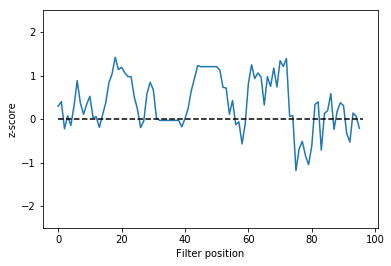

Plot for filter 2


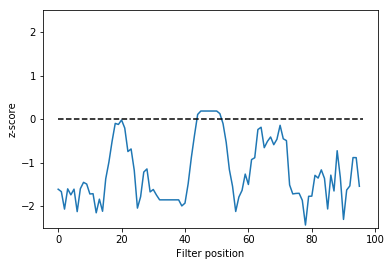

Plot for filter 3


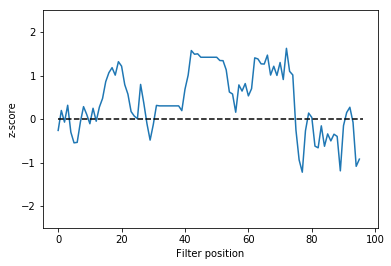

Plot for filter 4


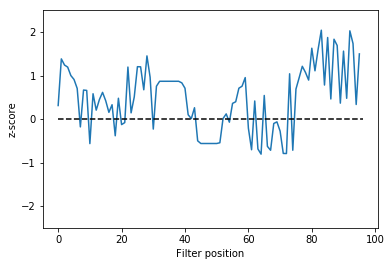

Plot for filter 5


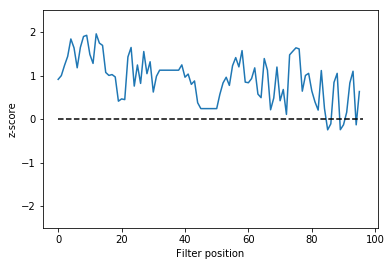

Plot for filter 6


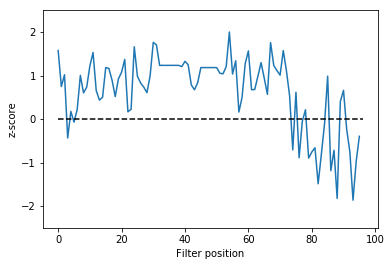

Plot for filter 7


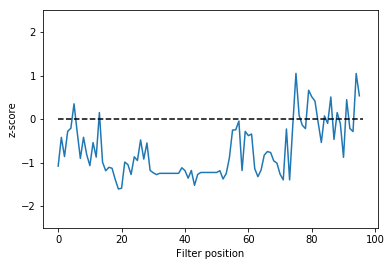

Plot for filter 8


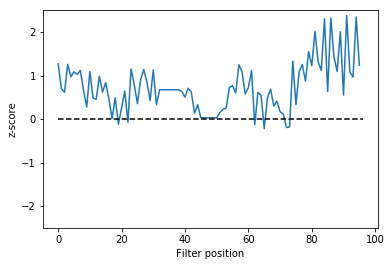

Plot for filter 9


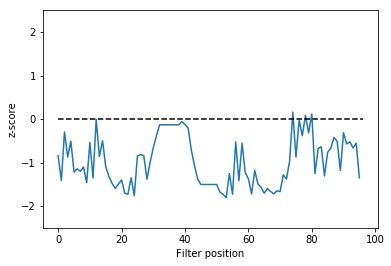

Plot for filter 10


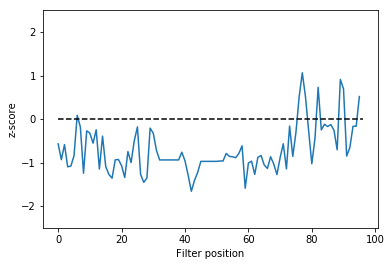

In [55]:
from scipy import stats

activations_s = np.transpose(np.squeeze(activations))
norm_activations = stats.zscore(activations_s)
#print(activations_s.shape)
#print(norm_activations)
for i in xrange(activations_s.shape[0]):
    print("Plot for filter {}".format(i+1))
    plt.ylim(-2.5,2.5)
    plt.plot(norm_activations[i,])
    plt.plot([0,96],[0,0], "k--")
    plt.xlabel("Filter position")
    plt.ylabel("z-score")
    plt.show()
plt.close()


In [55]:
print(np.amax(activations, axis = 2))

for position in activations.reshape(-1,1):
    print position

[[0.5106516  0.5190421  0.7593263  0.4065956  0.26387578 0.5054996
  0.38625944 0.20601396 0.52035004 0.46936443 0.33829448 0.9272723
  0.44210085 0.5906661  0.6219534  0.472943   0.74702287 0.44165733
  0.47094017 0.5933884  0.4488642  0.29263768 0.512018   0.3050828
  0.30117774 0.47308972 0.6049093  0.23565906 0.5892661  0.5008084
  0.20420477 0.3597891  0.58381027 0.3700044  0.6377549  0.61188656
  0.4446969  0.369443   0.4860627  0.30725998 0.31740358 0.35070643
  0.12110586 0.3844614  0.4043685  0.27315092 0.4202204  0.43945926
  0.3665943  0.3152751  0.44348773 0.36576152 0.31517297 0.27926362
  0.36565918 0.27361503 0.644984   0.4166443  0.7113925  0.54134685
  0.44678456 0.37141132 0.2669718  0.47461322 0.34227937 0.15986289
  0.4113182  0.50977665 0.35262236 0.4227395  0.3525988  0.6249857
  0.32346404 0.45599464 0.35752386 0.30423096 0.31320053 0.42569813
  0.58838236 0.2881116  0.235086   0.35947418 0.23787574 0.36414444
  0.2645817  0.41394973 0.37745965 0.35195982 0.25974

[-0.23787634]
[0.44210085]
[-0.37140864]
[-0.55581075]
[-0.71973866]
[-0.23478882]
[-0.9218234]
[-0.6974746]
[-0.76096433]
[-0.0845686]
[-0.2514964]
[-0.12293304]
[-0.6104469]
[-0.45457703]
[0.00637244]
[-0.6703954]
[0.32172787]
[-0.3737895]
[-0.24252406]
[0.5906661]
[0.04358727]
[-0.13125044]
[-0.22146645]
[-0.29317498]
[-0.8395021]
[-0.27892295]
[-0.24884023]
[-0.5168968]
[-0.93495846]
[-1.0455724]
[0.02222376]
[-0.3469538]
[-0.99410427]
[-0.4012219]
[-0.01548871]
[-0.8673768]
[-0.20758563]
[-0.61010844]
[-0.07079811]
[-0.16586421]
[-0.30910906]
[-0.00089028]
[-0.5997447]
[-0.85452396]
[-0.5143744]
[0.07726698]
[-0.16248204]
[-0.28781915]
[-0.6798808]
[-0.1784121]
[-0.5515473]
[0.10528685]
[-0.34286603]
[-0.1569632]
[-0.00033253]
[-0.7611383]
[0.03029311]
[-0.06361163]
[-0.9937963]
[0.21907493]
[-0.06448273]
[0.19890931]
[0.04399009]
[-0.5492646]
[-0.73366505]
[-0.20795465]
[-0.5526912]
[-0.5447001]
[0.06417681]
[-0.02639149]
[-0.1591276]
[-0.27674374]
[-0.83939046]
[-0.3629247]
[0.0

[0.09151016]
[-0.32463068]
[-0.6172199]
[-0.85077107]
[-0.18826407]
[-0.51874924]
[-0.49786958]
[0.16528708]
[-0.01367656]
[-0.7684356]
[-0.25225812]
[-0.28471318]
[-0.4414185]
[-0.3888318]
[-0.1606409]
[-0.04524498]
[-0.61221796]
[-0.38060877]
[-0.10890262]
[-0.12076382]
[-0.48162878]
[-0.31773785]
[-0.54787636]
[-0.47763392]
[-0.10580456]
[0.30117774]
[-0.08963852]
[-0.518787]
[-0.23847786]
[-0.39736465]
[-0.22462632]
[0.04209429]
[-0.68847966]
[0.27855706]
[-0.10849332]
[-0.0318168]
[-0.38665092]
[-0.45858365]
[-0.4064956]
[-0.06141043]
[-0.49990994]
[-0.21680658]
[-0.40977797]
[-0.08260845]
[0.07810049]
[-0.16332528]
[-0.34127697]
[-0.14002387]
[-0.09698401]
[-0.21057968]
[0.23550777]
[-0.41536397]
[0.03030646]
[-0.09798266]
[0.00984668]
[-0.18582618]
[-0.29429972]
[-0.2569965]
[-0.380953]
[-0.304548]
[-0.05017058]
[-0.698807]
[-0.93806136]
[-1.0817162]
[0.2847076]
[-0.5197785]
[-0.6043201]
[-0.90244704]
[0.24636626]
[-0.7108183]
[-0.6141608]
[-0.87241906]
[-0.35814396]
[-0.255163]

[-0.37973392]
[0.4446969]
[-0.19222414]
[-0.5061387]
[-0.520738]
[-0.5524115]
[-0.20688678]
[0.20173836]
[-0.47083974]
[-0.5963496]
[-0.0922624]
[0.13232478]
[-0.03607292]
[-0.36411503]
[-0.26374018]
[-0.4170788]
[-0.5279206]
[-0.5933276]
[-0.5338758]
[-0.16582449]
[0.0021549]
[-0.4063871]
[0.01798393]
[-0.5466912]
[-0.17395198]
[-0.3811422]
[-0.03327921]
[-0.14317413]
[-0.25623962]
[0.05271087]
[-0.26997674]
[-0.25883588]
[-0.0339167]
[0.05304147]
[-0.7604383]
[0.1214196]
[-0.47222525]
[-0.6093141]
[-0.92285514]
[-0.9667574]
[-0.08398631]
[-0.5465022]
[-0.3798819]
[-0.45410693]
[0.369443]
[-0.6788908]
[-0.24972832]
[-0.5250545]
[-0.20905362]
[-0.03850492]
[-0.3476992]
[0.14989832]
[-0.20720851]
[-0.70553285]
[-0.17534035]
[0.36767912]
[-0.41970515]
[-0.02149696]
[-0.564044]
[-0.18907689]
[-0.00763493]
[0.24119912]
[0.1000797]
[-0.50134623]
[-0.60475314]
[-0.09808031]
[-0.0039542]
[-0.29428408]
[-0.9296804]
[-0.37548545]
[-0.1628692]
[0.18563762]
[-0.18007016]
[-0.56226224]
[-0.2609098

[-0.33816582]
[0.24809723]
[-0.5016914]
[0.16733906]
[0.02709646]
[0.3152751]
[-0.0086499]
[-0.46438166]
[-0.48981264]
[-0.2410272]
[-0.03248128]
[-0.06440601]
[-0.6079085]
[-0.51990455]
[-0.43112332]
[-0.03891178]
[-0.12857082]
[-0.22223657]
[-0.00280689]
[-0.779601]
[-0.27479348]
[-0.16047518]
[-0.5135428]
[-0.16479857]
[0.09468561]
[-0.0862233]
[0.00406553]
[-0.53212535]
[0.2391547]
[-0.43933836]
[0.00911719]
[-0.14711662]
[-0.4649304]
[0.00513712]
[-0.5178777]
[-0.27897874]
[0.21740934]
[0.2068588]
[-0.35778624]
[-0.506712]
[-0.6848678]
[-0.38647157]
[-0.74345505]
[-0.94061756]
[-0.40635675]
[-0.8679424]
[-0.44484648]
[-0.2456204]
[-0.17620337]
[-0.65193516]
[-0.78986365]
[-0.6120565]
[-0.23791875]
[-0.68186414]
[-0.8639548]
[-0.10708837]
[-0.6070098]
[-0.48534694]
[-0.5400428]
[-0.20917451]
[-0.58490217]
[-0.48139235]
[-0.33526024]
[-0.3028098]
[-0.08899991]
[-0.04491664]
[-0.0985297]
[-0.41355684]
[-0.59233]
[-0.52503115]
[-0.3908934]
[0.0252952]
[-0.46742302]
[-0.30207676]
[0.04

[-0.27484384]
[0.17529157]
[-0.19532546]
[-0.4110033]
[-0.04877311]
[-0.39214498]
[-0.38891476]
[-0.32710624]
[-0.47546396]
[-0.23817876]
[-0.51175094]
[-0.07409354]
[-0.01966556]
[0.01177669]
[-0.3591236]
[-0.25620762]
[-0.19325273]
[-0.11022796]
[-0.46465725]
[-0.7822573]
[-0.2932083]
[-0.7689952]
[-0.5175017]
[-0.21776974]
[-0.06076888]
[-0.55972606]
[-0.62799245]
[-0.76131856]
[-0.23811774]
[-0.35184205]
[-0.8028523]
[-0.35375875]
[0.06779641]
[-0.53969604]
[-0.11978595]
[0.02931273]
[-0.36048597]
[-0.20500861]
[-0.52796334]
[-0.23438673]
[0.1989189]
[0.24105106]
[0.2669718]
[-0.41105977]
[-0.5401491]
[-0.19288379]
[-0.23718658]
[-0.31547424]
[-0.04131576]
[-0.60680693]
[-0.11792024]
[0.16243893]
[-0.3783995]
[-0.5481455]
[0.12886578]
[-0.40173948]
[-0.2847139]
[-0.44080904]
[-0.44499573]
[-0.18137826]
[0.12401825]
[-0.07037461]
[-0.20266673]
[0.03662317]
[0.1401221]
[-0.45755717]
[-0.17008182]
[-0.04821113]
[-0.49713364]
[-0.15894637]
[-0.3734325]
[-0.30103776]
[0.08873917]
[-0.12

[0.31370845]
[-0.11273277]
[-0.45551786]
[-0.21106589]
[0.00516766]
[-0.30919555]
[-0.16868652]
[-0.3817663]
[-0.0463228]
[-0.11067936]
[-0.11561508]
[-0.3324262]
[0.2916608]
[0.04551035]
[-0.63537383]
[-0.57210195]
[-0.45831776]
[-0.3303094]
[-0.00776037]
[-0.47145775]
[-0.4102215]
[0.10962225]
[-0.0122988]
[-0.45403922]
[-0.29429558]
[-0.12611829]
[-0.09841685]
[-0.461998]
[-0.71052265]
[-0.6317479]
[-0.36925036]
[-0.9824468]
[-0.23126227]
[-0.22767058]
[-0.2330839]
[-0.41860119]
[-0.62988085]
[-0.14899002]
[-0.02331381]
[-0.26277944]
[-0.21232897]
[-0.11856465]
[-1.0078441]
[-0.7161981]
[-0.06788592]
[0.12248538]
[-0.15713881]
[-0.46653047]
[-0.5748819]
[0.07040239]
[0.08814086]
[-0.2200777]
[-0.08190013]
[-0.17081407]
[-0.22352085]
[-0.09899919]
[-0.30358914]
[-0.06147499]
[-0.02274527]
[-0.265174]
[0.30423096]
[-0.10716876]
[-0.10989643]
[-0.111579]
[0.07437125]
[0.1508794]
[0.1130202]
[-0.295333]
[-0.15603222]
[-0.13838595]
[-0.18949696]
[-0.09186125]
[0.0428467]
[0.12482338]
[-0

[-0.45018467]
[0.1192321]
[0.05416048]
[-0.77669406]
[0.01141369]
[-0.65644807]
[-0.50960606]
[-0.5656042]
[-0.8148545]
[-0.2978896]
[-0.61092496]
[-0.15093721]
[-0.28482762]
[0.08339707]
[-0.46029377]
[-0.4945841]
[-0.5373723]
[-0.5797661]
[-0.0645807]
[-0.314056]
[-0.31236404]
[0.04907701]
[-0.5117311]
[-0.12730314]
[-0.02504689]
[-0.33453846]
[-0.33177528]
[-0.5264315]
[-0.43749818]
[0.09273774]
[0.25974497]
[-0.14908928]
[-0.34807658]
[-0.70729077]
[-0.21414134]
[-0.2596788]
[-0.16536656]
[-0.54921615]
[-0.5634946]
[-0.16065787]
[0.06429925]
[-0.35754222]
[-0.26778013]
[0.1811572]
[-0.80016613]
[-0.34632567]
[-0.54546267]
[-0.22047123]
[-0.19312288]
[0.13832846]
[-0.2630796]
[0.09836689]
[-0.23407127]
[-0.06534269]
[-0.37127417]
[-0.3329118]
[-0.5103377]
[-0.5803981]
[-0.2779912]
[-0.5962733]
[-0.40723655]
[-0.25671673]
[-0.16993031]
[-0.5139618]
[0.36180708]
[-0.53937584]
[0.06400651]
[-0.35864758]
[-0.80312073]
[-0.07969886]
[-0.6783845]
[-0.48839435]
[-0.7591482]
[-0.09691246]
[

Using TensorFlow backend.


1_PARCLIP_AGO1234_hg19
(30000, 101, 36)
(<keras.layers.convolutional.Conv1D object at 0x7f21be69e5d0>, (6, 36, 10))
1
(101, 36)


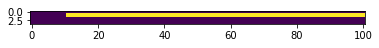

2
(101, 36)


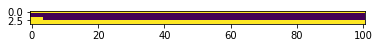

3
(101, 36)


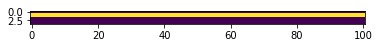

4
(101, 36)


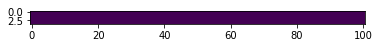

5
(101, 36)


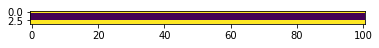

6
(101, 36)


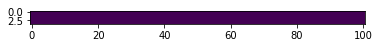

7
(101, 36)


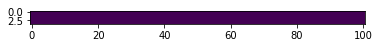

8
(101, 36)


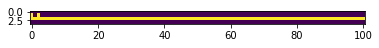

9
(101, 36)


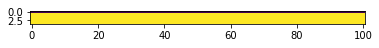

10
(101, 36)


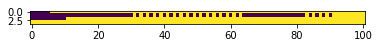

In [1]:
%matplotlib inline 

from keras.models import model_from_json
from keras import activations
from vis.visualization import visualize_activation
from vis.utils import utils
#30k datasets 
%matplotlib inline 

import numpy as np
from Bio import SeqIO
import gzip
import os
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



np.random.seed(454)


def load_data(path):   
    data = gzip.open(os.path.join(path,"sequences.fa.gz"),"rt")
    return data


def get_seq(protein, t_data, training_set_number): 
    if t_data == "train":
                
        training_data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((30000,101,4))          
    
    elif t_data == "test":    
                
        training_data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((10000,101,4))      
      
    r = 0    
      
    
    for record in SeqIO.parse(training_data,"fasta"):
        sequence = list(record.seq)                
        nucleotide = {'A' : 0, 'T' : 1, 'G' : 2, 'C' : 3, 'N' : 4} 
        num_seq = list() #sekvenca v številskem formatu


        for i in range(0,len(sequence)):
                num_seq.append(nucleotide[sequence[i]])


        X = np.zeros((1,len(num_seq),4))

        
        for i in range (len(num_seq)):
                if num_seq[i] <= 3:
                    X[:,i,num_seq[i]] = 1               

        x_train[r,:,:] = X
        r = r + 1
    
    return x_train


def get_class(protein, t_data,training_set_number):
    y_train = []
    

    if t_data == 'train':
        data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))

    elif t_data == 'test':
        data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))


    for record in SeqIO.parse(data,"fasta"):
        v = int((record.description).split(":")[1])
        # [1,0] if there was no observed binding and [0,1] for sequences where binding was observed.
        y_train.append([int(v == 0), int(v != 0)])

    y_train = np.array(y_train)
    return y_train


def get_cobinding(protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
            
        cobinding = np.zeros((30000,101,cobinding_data.shape[1]/101),dtype=np.int)    
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
        cobinding = np.zeros((10000,101,cobinding_data.shape[1]/101),dtype=np.int)
   
    
    for n in range(0,cobinding_data.shape[1],101):
        a = cobinding_data[:,n:(n+101)]
        cobinding[:,:,(n/101)] = a
    
    return cobinding
    

def get_region (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1)
        region = np.zeros((30000,101,region_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1) 
        region = np.zeros((10000,101,region_data.shape[1]/101),dtype=np.int)
    

    for n in range(0,region_data.shape[1],101):
        a = region_data[:,n:(n+101)]
        region[:,:,(n/101)] = a
        
    return region


def get_fold (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((30000,101,fold_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((10000,101,fold_data.shape[1]/101),dtype=np.int)




    for n in range(0,fold_data.shape[1],101):
        a = fold_data[:,n:(n+101)]
        fold[:,:,(n/101)] = a
    
    
    return fold

def load_data_sources(protein, t_data, training_set_number, *args):
    X = np.array([])
    data_sources = []
    for arg in args:
        
        if arg == 'KMER':
            if X.size == 0:
                X = get_seq(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_seq(protein, t_data, training_set_number)))
        if arg == 'RNA': 
            if X.size == 0:
                X = get_fold(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_fold(protein, t_data, training_set_number)))
        if arg == 'RG':   
            if X.size == 0:
                X = get_region(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_region(protein, t_data, training_set_number)))
        if arg == 'CLIP': 
            if X.size == 0:
                X = get_cobinding(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_cobinding(protein, t_data, training_set_number)))
        data_sources.append(arg)
        
    data_sources = ','.join(data_sources)
    return data_sources, X




protein_list = ["1_PARCLIP_AGO1234_hg19"]#, "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19"]#, "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
average_score = np.zeros(len(protein_list))
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']


for training_set_number in range (1):
        
    score_list = []
    
    for protein in protein_list:

        print (protein)

        data_sources, X = load_data_sources(protein, 'train', training_set_number, *experiment_set)
        y = get_class(protein,"train",training_set_number)
        print (X.shape)
        size = X.shape[2]
        score = []
        
        model = Sequential()
        model.add(Conv1D(10,6, data_format='channels_last', input_shape=(101, size) , strides = 1, padding='valid'))
        model.add(MaxPooling1D(pool_size=20, strides=1, padding='valid'))
        model.add(Conv1D(10, 4, activation='relu'))
        model.add(Dropout(0.1))
        model.add(MaxPooling1D(pool_size=40, strides=1, padding='valid'))
        model.add(Conv1D(15, 4, activation='relu'))
        model.add(MaxPooling1D(pool_size=30, strides=1, padding='valid'))
        model.add(Conv1D(15, 3, activation='relu'))
        model.add(GlobalAveragePooling1D())
        model.add(Dense(200, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(2, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        checkpointer = ModelCheckpoint(filepath="models/{}_weights.hdf5".format(protein), verbose=0, save_best_only=True)
        earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

        X_train = X
        y_train = y

        metrics = model.fit(X_train, y_train, validation_split = 0.2, epochs=12, batch_size=200, verbose=0, callbacks=[earlystopper])

        
        filters, biases = model.layers[0].get_weights()
            
        print (model.layers[0], filters.shape)

        layer_index = 0
        model.layers[layer_index].activation = activations.linear
        model = utils.apply_modifications(model)

        for i in xrange(filters.shape[2]):
            print (i+1)
            activation = visualize_activation(model, layer_index, filter_indices = i ,input_range = (0,2))
            print(activation.shape)
            plt.imshow((activation[:,0:4]).T)
            plt.show()

In [11]:
from keras import models
from keras.models import model_from_json
import h5py


def get_positive_samples(protein, t_data, training_set_number, *args ):
    data_sources, X_test = load_data_sources(protein, t_data, training_set_number, *args)
    y_test = get_class(protein, t_data, training_set_number)
    y_test = y_test [:,1]
    positive_samples = np.zeros((2000, X_test.shape[1], X_test.shape[2]))
    n = 0

    for i, value in enumerate(y_test):
        if value == 1:
            positive_samples[n] = X_test[i]
            n += 1 
 
    return positive_samples

def append_to_h5py(filter_num, protein, example, filter_activation):
    with h5py.File("results/set_0/{}/filter_activations.h5".format(protein), "a") as f:
        #Append sum of saliency over all layers 
                    dset = f[filter_num]
                    dset.resize((example + 1, 96,))
                    dset[example] = filter_activation
                    
protein_list = ["1_PARCLIP_AGO1234_hg19"]#, "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19"]#, "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
average_score = np.zeros(len(protein_list))
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']
training_set_number = 1


with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
    json = json_file.read()
    model = model_from_json(json)
    model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))

    layer = model.layers[0]
    activation_model = models.Model(inputs=model.input, outputs=layer.output)

    example = 0
    sample = np.expand_dims(get_positive_samples(protein, "test", training_set_number, *experiment_set)[example,], axis=0)

    print(sample.shape)
    activations = activation_model.predict(sample)
    print(activations[:,:,0])

    with h5py.File("results/set_0/{}/filter_activations.h5".format(protein), "w") as f:
        for i in xrange(10):
            dset = f.create_dataset(str(i), dtype="f", shape=(0, 96) , maxshape=(None, 96), chunks=(1, 96))

    for filter_num in xrange(activations.shape[2]):
        filter_activation = (activations[:,:,i]).flatten()
        print(filter_num)
        append_to_h5py(str(filter_num), protein, example, filter_activation)
        
#     plt.xticks(np.arange(0, 101, 10), np.arange(-50,50,10))
#     plt.plot(activations[:, :, i].T)
#     plt.show()
# plt.close()


(1, 101, 36)


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1d_5/convolution/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv1d_5/convolution/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, conv1d_5/convolution/ExpandDims_1)]]

In [6]:
import h5py
protein = "1_PARCLIP_AGO1234_hg19"
with h5py.File("results/set_0/{}/filter_activations".format(protein), "r") as f:
    dset = f["1"]
    print(dset, f.keys())
    

(<HDF5 dataset "1": shape (1, 96), type "<f4">, [u'0', u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9'])


In [80]:
import itertools
colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c"]
row_colors = list(itertools.chain.from_iterable(itertools.repeat(x, 10) for x in colors))

        
print(colors)

['#9b59b6', '#9b59b6', '#9b59b6', '#3498db', '#3498db', '#3498db', '#95a5a6', '#95a5a6', '#95a5a6', '#e74c3c', '#e74c3c', '#e74c3c', '#34495e', '#34495e', '#34495e', '#2ecc71', '#2ecc71', '#2ecc71']
